### Прогнозирование стоимости автомобиля по характеристикам

По условию соревнования, нам нужно самостоятельно собрать обучающий датасет

### Setup

In [353]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold 
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from datetime import timedelta, datetime, date


Фиксирую RANDOM_SEED, чтобы эксперименты были воспроизводимы!

In [450]:
RANDOM_SEED = 42
VAL_SIZE   = 0.33   # 33%
N_FOLDS    = 5

# CATBOOST
ITERATIONS = 2000
LR         = 0.1

In [458]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 (default, Jan  8 2020, 13:42:34) 
Numpy        : 1.18.1


In [463]:
# Зададим переменные пути для скачивания исходных файлов и загрузки итогового
DIR_TRAIN  = '/Users/oabazhanova/Documents/Python/unit_3/' 
DIR_TEST   = '/Users/oabazhanova/Documents/Python/unit_3/'

In [464]:
train = pd.read_csv(DIR_TRAIN + 'train_new.csv') # мой подготовленный датасет для обучения модели
test = pd.read_csv(DIR_TEST + 'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Парсинг обучающей выборки. 

In [ ]:
#Парсила сайт auto.ru для каждой модели и списка MODELS (представлены в тестовой выборке)
#проход по моделям, а внутри моделей цикл по страницам и формирование списка ссылок
#MODELS = ['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
#          'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI']

#парсинг характеристик автомобиля, создание функции car_info

'''''def car_info(url):
    response = requests.get(url)    
    response.encoding ='utf8' 
    page = BeautifulSoup(response.text, 'html.parser')
    brand = url.split('/')[6]
    model = url.split('/')[7]
    
    
    #sell_id = page.find_all('div',class_= 'pur7KbGcwjmSm7EcZStf8__info-item')[2].text.replace('№ ','')

    try:
        sell_id = url.split('/')[8][0:10]
    except:
        sell_id = 'Nan'
    try:        
        year = page.find('li', class_= 'CardInfoRow_year').find('a','Link Link_color_black').text
    except:
        year = 'Nan'
    try:
        mileage =  page.find('li', class_= 'CardInfoRow_kmAge').find_all('span','CardInfoRow__cell')[1].text.replace(u'\xa0', u'')
    except:
        mileage = 'Nan'
    try:
        body_type = page.find('li', class_= 'CardInfoRow_bodytype').find('a','Link Link_color_black').text
    except:
        body_type = 'Nan'
    try:
        color = page.find('li', class_= 'CardInfoRow_color').find_all('span','CardInfoRow__cell')[1].text
    except:
        color = 'Nan'
    try:
        enginePower = page.find('li', class_= 'CardInfoRow_engine').find('div').text.replace(u'\xa0', u'').split('/')[0].strip()
    except:
        enginePower = 'Nan'
    try:
        engineDisplacement = page.find('li', class_= 'CardInfoRow_engine').find('div').text.replace(u'\xa0', u'').split('/')[1].strip()
    except:
        engineDisplacement = 'Nan'
    try:
        fuelType = page.find('li', class_= 'CardInfoRow_engine').find('div').text.replace(u'\xa0', u'').split('/')[2].strip()
    except:
        fuelType = 'Nan'
    try:
        vehicleTransmission =  page.find('li', class_= 'CardInfoRow_transmission').find_all('span','CardInfoRow__cell')[1].text
    except:
        vehicleTransmission = 'Nan'
    try:    
        Привод = page.find('li', class_= 'CardInfoRow_drive').find_all('span','CardInfoRow__cell')[1].text
    except:
        Привод = 'Nan'
    try:
        Руль = page.find('li', class_= 'CardInfoRow_wheel').find_all('span','CardInfoRow__cell')[1].text
    except:
        Руль = 'Nan'
    try:
        Состояние = page.find('li', class_= 'CardInfoRow_state').find_all('span','CardInfoRow__cell')[1].text
    except:
        Состояние = 'Nan'
    try:
        Владельцы = page.find('li', class_= 'CardInfoRow_ownersCount').find_all('span','CardInfoRow__cell')[1].text[0]
    except:
        Владельцы = 'Nan'
    try:
        ПТС = page.find('li', class_= 'CardInfoRow_pts').find_all('span','CardInfoRow__cell')[1].text
    except:
        ПТС = 'Nan'
    try:
        Таможня = page.find('li', class_= 'CardInfoRow_customs').find_all('span','CardInfoRow__cell')[1].text
    except:
        Таможня = 'Nan'
    try:
        price = page.find('span', class_='OfferPriceCaption__price').text.replace(u'\xa0', u'')
    except:
        price = 'Nan'
    new_line = [sell_id, brand, model, year, mileage, body_type, color, enginePower, engineDisplacement, fuelType, vehicleTransmission, Привод, Руль, Состояние, Владельцы, ПТС, Таможня, price]
    return new_line

#Создание списков для работы 
#link_list=[]
#links=[]
#links_done=[]

#Создание/обновление датафрейма
#df = pd.DataFrame(columns=['sell_id', 'brand', 'model', 'year', 'mileage', 'body_type', 
#                           'color', 'enginePower', 'engineDisplacement', 'fuelType', 
#                           'vehicleTransmission', 'Привод', 'Руль', 'Состояние', 
#                           'Владельцы', 'ПТС', 'Таможня', 'price'])

In [ ]:
'''''start = datetime.now()
print(start)

MODELS = [
#    'SKODA', 
#    'AUDI', 
#    'HONDA', 
#    'VOLVO', 
#    'BMW', 
#    'NISSAN', 
#    'INFINITI',
#    'MERCEDES', 
#    'TOYOTA', 
    'LEXUS', 
#    'VOLKSWAGEN', 
#    'MITSUBISHI'
    ]

pages = 100

for model in MODELS:
    for p in range(1,pages+1):
        url = f'https://auto.ru/cars/{model}/used/?page={p}'
        response = requests.get(url)  
        response.encoding ='utf8'
        soup = BeautifulSoup(response.text, 'html.parser') 
        link = soup.find_all('a', class_='Link ListingItemTitle-module__link')
        link_list = list(map(lambda x: x.get('href'), link))
        links = links + link_list
        if len(link_list) == 0:
            break

finish = datetime.now()
delta = finish - start
print(finish)
print(delta)
len(links)

#Проверяю наполненность списка ссылок и списка отработанных ссылок перед следующим шагом
print(len(links))
print(len(links_done))

start = datetime.now()
print(start)

#Применяю фукцию по вытаскиванию характеристик автомобиля к каждой ссылке из списка, 
#формирую список отработанных ссылок
for l in links:
    try:
        df.loc[len(df)] = car_info(l)
        links_done.append(l)
    except:
        continue

#Удаляю сразу на данном этапе дубликаты из датасета и сбрасываю индексы
df = df.drop_duplicates()
df = df.reset_index(drop=True)

#Записываю в файл
df.to_csv('train_new.csv', encoding='utf-8', index=False)
        
finish = datetime.now()
delta = finish - start
print(finish)
print(delta)

#Удаляю из списка ссылок отработанные ссылки
for l in links_done:
    try:
        links.remove(l)
    except:
        continue
        
#Проверяю наполненность списка ссылок и списка отработанных ссылок по результатам
print(len(links))
print(len(links_done))

#При наличии неотработанных ссылок возвращаюсь на предыдущий шаг

df_old = pd.read_csv('train.csv')

df = pd.concat([df, df_old])

#Удаляю сразу на данном этапе дубликаты из датасета и сбрасываю индексы
df = df.drop_duplicates()
df = df.reset_index(drop=True)

#Записываю в файл
df.to_csv('train_new.csv', encoding='utf-8', index=False)


Напарсила в трейновый датасет 45269 строк и 18 колонок.

**Функции**

In [376]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


def bar_train(column):


    fig, axes = plt.subplots(figsize=(12, 6))
    
    sns.barplot(x=df_train[column].astype(str).value_counts().index[:5],
                y=df_train[column].value_counts(normalize=True).values[:5],
                palette='magma')
    plt.title(f'Top train categories for "{column}"',
              size=15)
    plt.ylabel('Proportion')
    
    plt.xticks(rotation=90)
    plt.subplots_adjust(wspace=0.2);
    
def bar_test(column):


    fig, axes = plt.subplots(figsize=(12, 6))
    
    sns.barplot(x=test[column].astype(str).value_counts().index[:5],
                y=test[column].value_counts(normalize=True).values[:5],
                palette='magma')
    plt.title(f'Top test categories for "{column}"',
              size=15)
    plt.ylabel('Proportion')
    
    plt.xticks(rotation=90)
    plt.subplots_adjust(wspace=0.2);
    

#Выбросы
def statistic_test(col):
    median = test[col].median()
    IQR = test[col].quantile(0.75) - test[col].quantile(0.25)
    perc25 = test[col].quantile(0.25)
    perc75 = test[col].quantile(0.75)
    l=perc25 - 1.5*IQR 
    r=perc75 + 1.5*IQR
    print("Для {0} IQR: {1}, ".format(col,IQR),"Границы выбросов: [{0}, {1}].".format(l, r))
    print('Всего {} выбросов'.format(test[test[col] > r][col].count()+test[test[col] < l][col].count()))

    
def statistic_train(col):
    median = train[col].median()
    IQR = train[col].quantile(0.75) - train[col].quantile(0.25)
    perc25 = train[col].quantile(0.25)
    perc75 = train[col].quantile(0.75)
    l=perc25 - 1.5*IQR 
    r=perc75 + 1.5*IQR
    print("Для {0} IQR: {1}, ".format(col,IQR),"Границы выбросов: [{0}, {1}].".format(l, r))
    print('Всего {} выбросов'.format(train[train[col] > r][col].count()+train[train[col] < l][col].count()))
    
#графики боксплотов для переменных и логарифмированных переменных
def dist_box(data, column):
 
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    sns.kdeplot(data[column], ax=axes[0][0],
                color='r', shade=True)
    axes[0][0].set_title(f'Distribution for "{column}"',
                      size=15)
    sns.boxplot(data[column], ax=axes[0][1],
                color='r', meanline=True)
    axes[0][1].set_title(f'Box plot for "{column}"',
                      size=15)
    
    sns.kdeplot(np.log(data[column] + 1), ax=axes[1][0],
                color='violet', shade=True)
    axes[1][0].set_title(f'Log-distribution for "{column}"',
                      size=15)
    
    sns.boxplot(np.log(data[column] + 1), ax=axes[1][1],
                color='violet', meanline=True)
    axes[1][1].set_title(f'Box plot for logarithmic "{column}"',
                      size=15)

    plt.subplots_adjust(wspace=0.1, hspace=0.3);



### Data

In [355]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train_new.csv')

In [356]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45269 entries, 0 to 45268
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   sell_id              45269 non-null  object
 1   brand                45269 non-null  object
 2   model                45269 non-null  object
 3   year                 45269 non-null  object
 4   mileage              45269 non-null  object
 5   body_type            45269 non-null  object
 6   color                45269 non-null  object
 7   enginePower          45269 non-null  object
 8   engineDisplacement   45269 non-null  object
 9   fuelType             45269 non-null  object
 10  vehicleTransmission  45269 non-null  object
 11  Привод               45269 non-null  object
 12  Руль                 45269 non-null  object
 13  Состояние            45269 non-null  object
 14  Владельцы            45269 non-null  object
 15  ПТС                  45269 non-null  object
 16  Тамо

In [357]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

- В тестовом датасете 34684 строк и 32 колонки.

In [358]:
train.columns = ['sell_id','brand','model_name','productionDate','mileage','bodyType','color','engineDisplacement','enginePower','fuelType','vehicleTransmission','Привод','Руль','Состояние','Владельцы','ПТС','Таможня','price']
    

Посмотрим количество уникальных значений в датасете.

In [359]:
test.nunique()

bodyType                   24
brand                      12
car_url                 34686
color                      16
complectation_dict       2364
description             31732
engineDisplacement         55
enginePower               315
equipment_dict          23705
fuelType                    5
image                   34557
mileage                 11268
modelDate                  66
model_info                954
model_name                544
name                     2780
numberOfDoors               5
parsing_unixtime        34686
priceCurrency               1
productionDate             69
sell_id                 34686
super_gen                5890
vehicleConfiguration      634
vehicleTransmission         4
vendor                      2
Владельцы                   3
Владение                  275
ПТС                         2
Привод                      3
Руль                        2
Состояние                   1
Таможня                     1
dtype: int64

- В тестовой выборке, предложенной на каггле, мы имеем 31 признак: int64(6) - числовых 6, object(26) - типа object 26.

In [360]:
train.nunique()

sell_id                44845
brand                     12
model_name               575
productionDate            57
mileage                16030
bodyType                  25
color                     17
engineDisplacement        53
enginePower              318
fuelType                   8
vehicleTransmission        5
Привод                     4
Руль                       3
Состояние                  3
Владельцы                  4
ПТС                        3
Таможня                    2
price                   5285
dtype: int64

- В трейновом датасете мы имеем 45269 строк.
- Рассмотрим каждый признак внимательнее.

In [320]:
#Признак bodyType - это тип кузова. Содержит 24 уникальных значения.
print('число уникальных значений признака bodyType ', len(test.bodyType.unique()))
print(list(test.bodyType.unique()))

число уникальных значений признака bodyType  24
['лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'седан', 'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина', 'хэтчбек 3 дв.', 'купе', 'кабриолет', 'минивэн', 'пикап двойная кабина', 'внедорожник 3 дв.', 'родстер', 'микровэн', 'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга', 'внедорожник открытый', 'лимузин', 'пикап полуторная кабина', 'седан-хардтоп', 'фургон']


In [322]:
print('число уникальных значений признака bodyType ', len(train.body_type.unique()))
list(train.body_type.unique())

число уникальных значений признака bodyType  25


['хэтчбек 5 дв.',
 'лифтбек',
 'внедорожник 5 дв.',
 'универсал 5 дв.',
 'Nan',
 'седан',
 'компактвэн',
 'универсал 3 дв.',
 'купе',
 'хэтчбек 3 дв.',
 'кабриолет',
 'родстер',
 'седан 2 дв.',
 'пикап двойная кабина',
 'минивэн',
 'микровэн',
 'внедорожник 3 дв.',
 'купе-хардтоп',
 'пикап полуторная кабина',
 'фастбек',
 'фургон',
 'тарга',
 'седан-хардтоп',
 'пикап одинарная кабина',
 'внедорожник открытый']

In [361]:

# Создаю словарь, который укрупняет и приводит к единому формату некоторые описания кузовов
bodyTypes = {
        'внедорожник открытый': 'внедорожник',
        'внедорожник 5 дв.': 'внедорожник',
        'седан': 'седан',
        'лифтбек': 'хэтчбек',
        'хэтчбек 5 дв.': 'хэтчбек',
        'универсал 5 дв.': 'универсал',
        'минивэн': 'минивэн',
        'купе': 'купе',
        'компактвэн': 'минивэн',
        'хэтчбек 3 дв.': 'хэтчбек',
        'пикап двойная кабина': 'пикап',
        'внедорожник 3 дв.': 'внедорожник',
        'купе-хардтоп': 'купе',
        'кабриолет': 'кабриолет',
        'родстер': 'родстер',
        'фургон': 'фургон',
        'микровэн': 'минивэн',
        'седан-хардтоп': 'седан',
        'седан 2 дв.': 'седан',
        'пикап одинарная кабина': 'пикап',
        'лимузин': 'лимузин',
        'пикап полуторная кабина': 'пикап',
        'внедорожник открытый': 'внедорожник',
        'тарга': 'родстер',
        'фастбек': 'хэтчбек',
        'универсал 3 дв.1': 'универсал',
    }



In [362]:
test['bodyType_cut'] = test.bodyType.map(bodyTypes)
print(test.bodyType_cut.unique())
print('число уникальных значений признака bodyType_cut в test', len(test.bodyType_cut.unique()))

['хэтчбек' 'внедорожник' 'седан' 'минивэн' 'универсал' 'пикап' 'купе'
 'кабриолет' 'родстер' 'лимузин' 'фургон']
число уникальных значений признака bodyType_cut в test 11


In [364]:
train['bodyType_cut'] = train.bodyType.map(bodyTypes)
print(train.bodyType_cut.unique())
print('число уникальных значений признака bodyType_cut в train ', len(test.bodyType_cut.unique()))

['хэтчбек' 'внедорожник' 'универсал' nan 'седан' 'минивэн' 'купе'
 'кабриолет' 'родстер' 'пикап' 'фургон']
число уникальных значений признака bodyType_cut в train  11


In [365]:
#Рассмотрим признак brand. Уникальных значений 12.
print(len(test.brand.unique()))
test.brand.unique()

12


array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

Поскольку в тестовой выборке брэндов машин именно 12, то в парсинге я выкачиваю именно эти брэнды. 

In [366]:
train.brand.unique()

array(['skoda', 'audi', 'honda', 'volvo', 'bmw', 'nissan', 'infiniti',
       'mercedes', 'toyota', 'lexus', 'volkswagen', 'mitsubishi'],
      dtype=object)

In [367]:
#нужно регистр букв привести в единому формату
train['brand'] = [str(x).upper() for x in train['brand']]
train.brand.unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

In [368]:
#Признак car_url не несет никакой информации для нашей задачи. Его следует удалить. 
test.car_url[0:5]

0    https://auto.ru/cars/used/sale/skoda/octavia/1...
1    https://auto.ru/cars/used/sale/skoda/octavia/1...
2    https://auto.ru/cars/used/sale/skoda/superb/11...
3    https://auto.ru/cars/used/sale/skoda/octavia/1...
4    https://auto.ru/cars/used/sale/skoda/octavia/1...
Name: car_url, dtype: object

In [369]:
#Признак color имеет 16 уникальных значений. 
print(test.color.unique())
print(len(test.color.unique()))

['синий' 'чёрный' 'серый' 'коричневый' 'белый' 'пурпурный' 'бежевый'
 'серебристый' 'красный' 'зелёный' 'жёлтый' 'голубой' 'оранжевый'
 'фиолетовый' 'золотистый' 'розовый']
16


In [370]:
print(train.color.unique())
print(len(train.color.unique()))

['пурпурный' 'бежевый' 'коричневый' 'зелёный' 'белый' 'серый' 'синий'
 'серебристый' 'чёрный' 'красный' 'жёлтый' 'голубой' 'фиолетовый'
 'оранжевый' 'золотистый' 'розовый' 'Nan']
17


In [371]:
#Признак complectation_dict имеет очень много пропусков, а именно, 28268 значений пропущено. Это 77% от общего числа строк.
#Поэтому этот столбец нужно будет удалить. 
print(test.complectation_dict[0:10])
print('Число нулевых значений:',test.complectation_dict.isnull().sum())
print('Процент числа пропусков', 100 - (34686/28268 - 1)*100)

0                                                  NaN
1                                                  NaN
2    {"id":"20026336","name":"Ambition","available_...
3    {"id":"20803582","name":"Ambition","available_...
4                                                  NaN
5    {"id":"5011515","name":"RS","available_options...
6    {"id":"20069264","name":"Elegance","available_...
7                                                  NaN
8                                                  NaN
9                                                  NaN
Name: complectation_dict, dtype: object
Число нулевых значений: 28268
Процент числа пропусков 77.29588226970425


In [372]:
#Признак description удалим, так как его не понятно как обрабатывать. Он носит описательный характер. 
test.description

0        Все автомобили, представленные в продаже, прох...
1        ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...
2        Все автомобили, представленные в продаже, прох...
3        КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...
4        ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...
                               ...                        
34681    Продается BMW 316i в отличном состоянии. Прода...
34682                       Продаётся отличный автомобиль.
34683                                    Хорошее состояние
34684    Автомобиль в идеальном состоянии . Куплен новы...
34685     Пробег реальный, состояние отличное! Авторска...
Name: description, Length: 34686, dtype: object

In [378]:
#Этот признак нужно сделать числовым. Для этого надо удалить текст LTR и заменить пробелы на ноль.
train.drop(train[train.Владельцы == 'Nan'].index, inplace = True)
train.drop(train[train.enginePower == 'Nan'].index, inplace = True)
train.drop(train[train.ПТС == 'Nan'].index, inplace = True)
train.engineDisplacement = train.engineDisplacement.dropna()
train.engineDisplacement = train.engineDisplacement.str.replace(' л', '')
train.engineDisplacement = train.engineDisplacement.astype('float')
train.engineDisplacement = train.engineDisplacement.apply(lambda x: 100*x)
print(train.engineDisplacement)

AttributeError: Can only use .str accessor with string values!

In [379]:
test.engineDisplacement = test.engineDisplacement.str.replace(' LTR', '')
test.engineDisplacement = test.engineDisplacement.apply(lambda x: '0' if x=='' else x)
test.engineDisplacement = test.engineDisplacement.apply(lambda x: float(x))
test.engineDisplacement = test.engineDisplacement.apply(lambda x: 100*x)
    
    

In [380]:
statistic_test('engineDisplacement')

Для engineDisplacement IQR: 120.0,  Границы выбросов: [0.0, 480.0].
Всего 986 выбросов


In [381]:
#Возьмем логарифм параметра 'engineDisplacement' и посмотрим, как сократится количество выбросов. 
test['engineDisplacement_log'] = np.log(test['engineDisplacement'] + 1)
statistic_test('engineDisplacement_log')

Для engineDisplacement_log IQR: 0.5086132334830493,  Границы выбросов: [4.435577181041252, 6.470030114973449].
Всего 114 выбросов


Визуализация. Действительно, выбросов стало  почти в 10 раз меньше. Было 986, а стало 114.

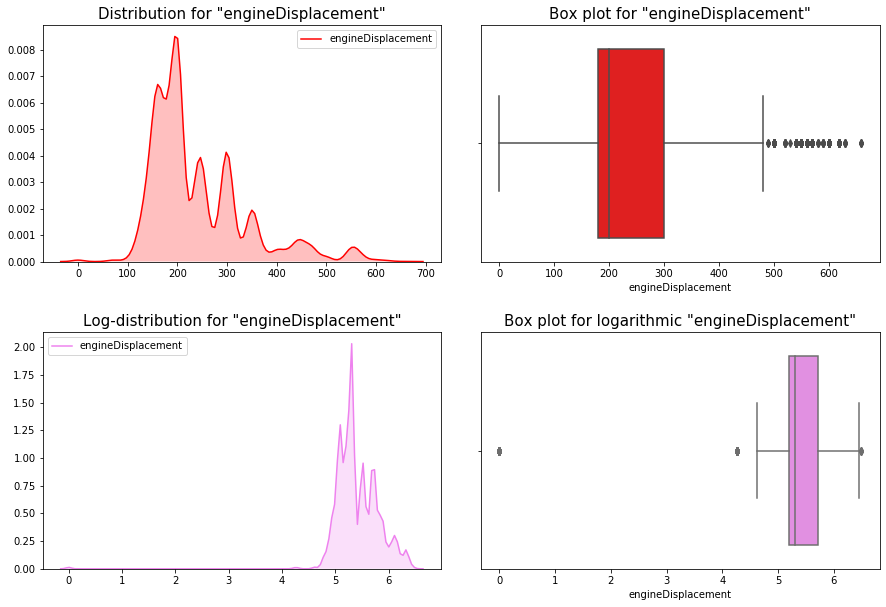

In [382]:
dist_box(test, 'engineDisplacement')

Посмотрим статистику в датасете train. 
- выбросов 1460

In [383]:
train.engineDisplacement
statistic_train('engineDisplacement')

Для engineDisplacement IQR: 120.0,  Границы выбросов: [0.0, 480.0].
Всего 1460 выбросов


Проанализируем признак мощность двигателя - 'enginePower'.

In [387]:
#Признак enginePower - мощность двигателя. Его нужно сделать числовым, удалив текст. 
test.enginePower = test.enginePower.str.replace(' N12', '')
test.enginePower = test.enginePower.apply(lambda x: float(x))
print(test.enginePower)

0        105.0
1        110.0
2        152.0
3        110.0
4        152.0
         ...  
34681    136.0
34682    190.0
34683    170.0
34684    184.0
34685    235.0
Name: enginePower, Length: 34686, dtype: float64


In [389]:
#Удаляю пропуски
print(test.enginePower.isnull().sum())
test.enginePower.dropna(inplace = True)

0


In [390]:
train.enginePower.unique()[0:10]

array(['105л.с.', '180л.с.', '150л.с.', '220л.с.', '75л.с.', '200л.с.',
       '152л.с.', '110л.с.', '102л.с.', '90л.с.'], dtype=object)

In [391]:
#Повторим замену для train. 
train.enginePower = train.enginePower.str.replace('л.с.', '')
train.enginePower = train.enginePower.apply(lambda x: float(x))
print(train.enginePower)

0        105.0
1        180.0
2        105.0
3        150.0
4        220.0
         ...  
45264    117.0
45265    146.0
45266    146.0
45267    146.0
45268    202.0
Name: enginePower, Length: 45164, dtype: float64


Статистика для самого признака и логарифма этого признака.

In [392]:
statistic_test('enginePower')

Для enginePower IQR: 108.0,  Границы выбросов: [-37.0, 395.0].
Всего 1219 выбросов


In [394]:
test['enginePower_log'] = np.log(test['enginePower'] + 1)
statistic_test('enginePower_log')

Для enginePower_log IQR: 0.6190392084062237,  Границы выбросов: [3.9077230943421424, 6.383879927967037].
Всего 88 выбросов


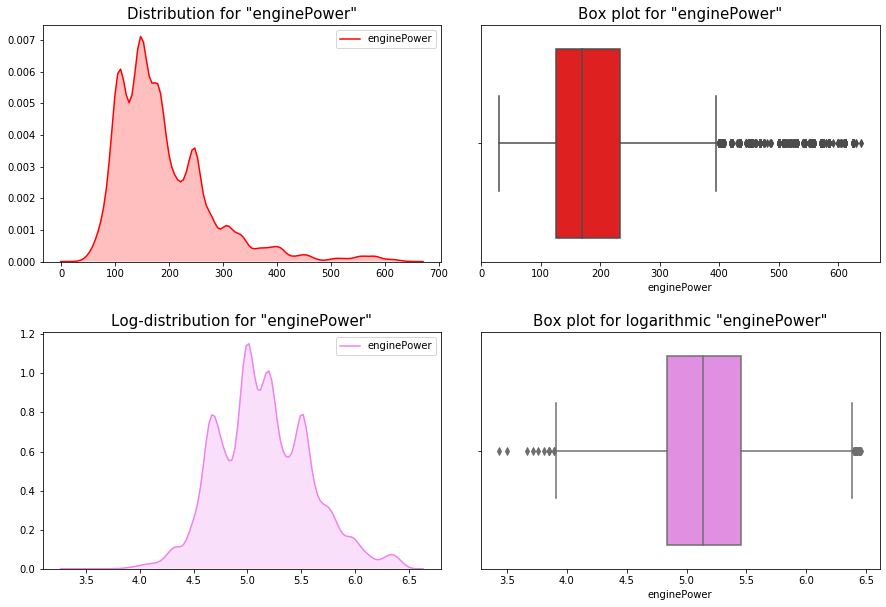

In [393]:
dist_box(test, 'enginePower')

Видно, что логарифм существенно сгладил распределение, оно стало более нормальным, а также выбросов стало меньше в 12 раз.

In [395]:
statistic_train('enginePower')

Для enginePower IQR: 102.0,  Границы выбросов: [-17.0, 391.0].
Всего 1581 выбросов


In [396]:
train['enginePower_log'] = np.log(train['enginePower'] + 1)
statistic_train('enginePower_log')

Для enginePower_log IQR: 0.556482626103386,  Границы выбросов: [4.085256986673047, 6.31118749108659].
Всего 539 выбросов


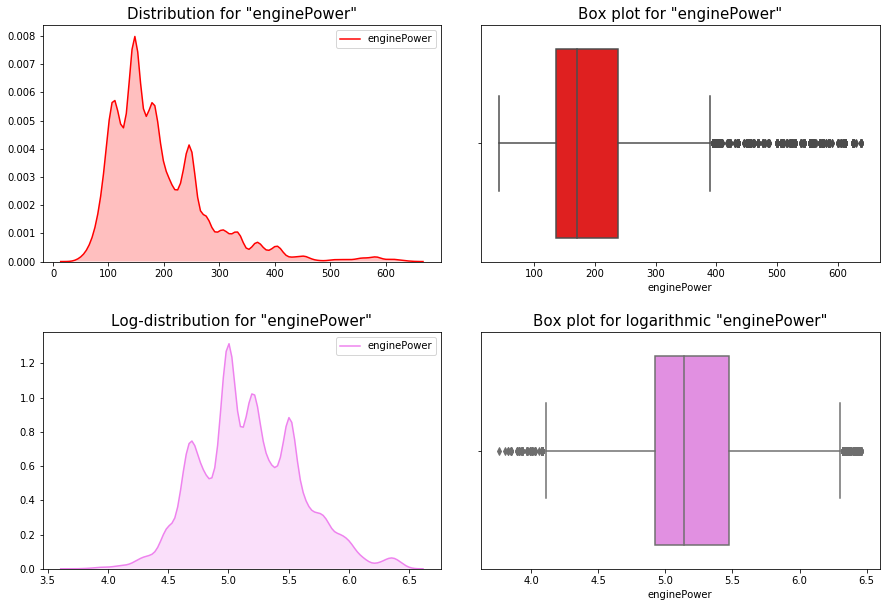

In [397]:
dist_box(train, 'enginePower')

In [398]:
#Признак equipment_dict содержит очень много пропусков, удалим его. 
test.equipment_dict.value_counts()
test.equipment_dict.isnull().sum()

9996

Признак fuelType - содержит 5 уникальных элементов: 'бензин', 'дизель', 'гибрид', 'электро', 'газ' и не содержит пустых значений.

In [399]:
print(test.fuelType.value_counts())
print(test.fuelType.isnull().sum())

test.fuelType.unique()



бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuelType, dtype: int64
0


array(['бензин', 'дизель', 'гибрид', 'электро', 'газ'], dtype=object)

In [400]:
#Для train делаю тоже самое, но сначала удяляю пропуски.
#df_train.fuelType.dropna(inplace = True)
#df_train.drop(df_train[df_train.fuelType == 'Nan'].index, inplace = True)
print(train.fuelType.value_counts())
print(train.fuelType.isnull().sum())

train.fuelType.unique()

Бензин                                36634
Дизель                                 7404
Гибрид                                  663
Бензин, газобаллонное оборудование      457
Газ, газобаллонное оборудование           3
Гибрид, газобаллонное оборудование        2
Газ                                       1
Name: fuelType, dtype: int64
0


array(['Бензин', 'Дизель', 'Бензин, газобаллонное оборудование', 'Гибрид',
       'Гибрид, газобаллонное оборудование',
       'Газ, газобаллонное оборудование', 'Газ'], dtype=object)

Привожу признак 'топливо' к формату test.

In [410]:
fuel_dict = {'Бензин':'бензин', 
             'Дизель': 'дизель',
             'Гибрид': 'гибрид',
             'Бензин, газобаллонное оборудование': 'газ',
             'Nan': 'электро',
             'Гибрид, газобаллонное оборудование': 'газ'  }
    
      
train['fuelType'] = train.fuelType.map(fuel_dict)

In [412]:
#train['fuelType'] = train.fuelType.map(fuel_dict)
print(train.fuelType.unique())
print('число уникальных значений признака fuelType в train ', len(train.fuelType.unique()))

[nan]
число уникальных значений признака fuelType в train  1


In [414]:
#Признак image удаляем, ссылки на фотографии мы никак пока не можем обработать.
test.image.sample(3)

9962     https://autoru.naydex.net/lICN99c69/9bc7d3Rr7k...
30053    https://avatars.mds.yandex.net/get-autoru-vos/...
11875    https://autoru.naydex.net/G87gDZg56/28c7a8vqVE...
Name: image, dtype: object

In [415]:
#Признак mileage означает пробег. Он числовой, оставим его так, как есть.
test.mileage.value_counts()

200000    436
150000    382
300000    381
180000    347
250000    346
         ... 
109473      1
299910      1
101253      1
23423       1
73732       1
Name: mileage, Length: 11268, dtype: int64

In [419]:
#Удалим в трейне единицу измерения 'км'.
print(train.mileage)
train.mileage = train.mileage.str.replace('км', '')
train.mileage = train.mileage.apply(lambda x: float(x))

0        168000.0
1         64000.0
2        140257.0
3         31301.0
4        160000.0
           ...   
45264    114000.0
45265    154638.0
45266     12430.0
45267     33018.0
45268    150000.0
Name: mileage, Length: 45164, dtype: float64


AttributeError: Can only use .str accessor with string values!

In [420]:
statistic_test('mileage')

Для mileage IQR: 123846.5,  Границы выбросов: [-94616.25, 400769.75].
Всего 692 выбросов


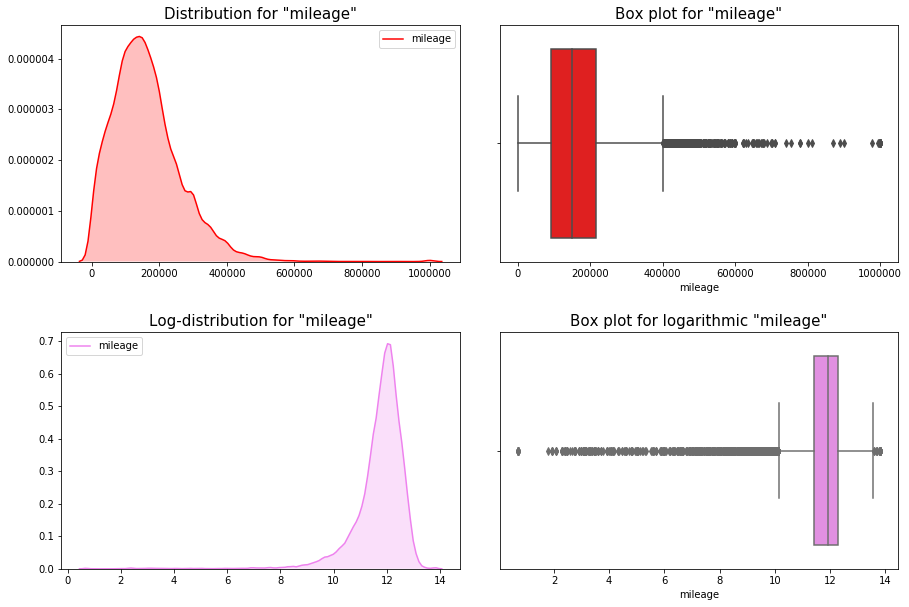

In [421]:
dist_box(test, 'mileage')

In [423]:
print(train.mileage)

0        168000.0
1         64000.0
2        140257.0
3         31301.0
4        160000.0
           ...   
45264    114000.0
45265    154638.0
45266     12430.0
45267     33018.0
45268    150000.0
Name: mileage, Length: 45164, dtype: float64


In [422]:
print(test.modelDate.describe())
print(test.modelDate.isnull().sum())

count    34686.000000
mean      2007.074728
std          7.415894
min       1904.000000
25%       2004.000000
50%       2008.000000
75%       2012.000000
max       2020.000000
Name: modelDate, dtype: float64
0


In [424]:
print(train.productionDate.describe())
print(train.productionDate.isnull().sum())

count     45164
unique       56
top        2012
freq       3428
Name: productionDate, dtype: object
0


In [425]:
#Признаки model_info тоже удалим
print(test.model_info[0:10])

0    {"code":"OCTAVIA","name":"Octavia","ru_name":"...
1    {"code":"OCTAVIA","name":"Octavia","ru_name":"...
2    {"code":"SUPERB","name":"Superb","ru_name":"Су...
3    {"code":"OCTAVIA","name":"Octavia","ru_name":"...
4    {"code":"OCTAVIA","name":"Octavia","ru_name":"...
5    {"code":"OCTAVIA_RS","name":"Octavia RS","ru_n...
6    {"code":"YETI","name":"Yeti","ru_name":"Йети",...
7    {"code":"OCTAVIA","name":"Octavia","ru_name":"...
8    {"code":"KODIAQ","name":"Kodiaq","ru_name":"Ко...
9    {"code":"YETI","name":"Yeti","ru_name":"Йети",...
Name: model_info, dtype: object


In [426]:
train.model_name.value_counts()

octavia          1578
rx               1344
polo             1242
tiguan            953
outlander         900
                 ... 
q2                  1
almera_tino         1
z8                  1
tt_rs               1
nv350_caravan       1
Name: model_name, Length: 569, dtype: int64

In [427]:
test.model_name.value_counts()

OCTAVIA       1418
5ER           1026
LANCER         855
E_KLASSE       809
PASSAT         782
              ... 
RACTIS           1
POLO_GTI         1
W114             1
SPARKY           1
100_SERIES       1
Name: model_name, Length: 544, dtype: int64

In [429]:
#нужно регистр букв привести в единому формату
train['model_name'] = [str(x).upper() for x in train['model_name']]
train.model_name.unique()[0:10]

array(['FABIA', 'OCTAVIA', 'YETI', 'KODIAQ', 'OCTAVIA_RS', 'RAPID',
       'SUPERB', 'KAROQ', 'ROOMSTER', 'FELICIA'], dtype=object)

In [313]:
#выделим топ-80 моделей (из 544), которые составляют 79 процентов записей в df_test. 
#m_all = df_test.model_name.value_counts()
#n = 0
#p = 0
#for m in m_all.index:
#    n = n + 1
#    p = p + m_all[m]
#    if p >= (len(df_test)*79/100):
#        break
#m_top = m_all.head(n).index
#len(m_top)

#функция, которая заменяет нетоповые модели на другие 'Other'.
#def mod_top(x):
#    if x in m_top:
#        return x
#    else:
#        return 'Other'

#test['model_top'] = test['model_name'].apply(mod_top)
#test.model_top.value_counts()
#Признак 'model_name' удалю, поскольку создала новую колонку 'model_top'.

In [431]:
#Признак numberOfDoors - количество дверей в автомобиле. Тут есть одна позиция вообще без единой двери.
print(test.numberOfDoors.value_counts())
#Такая машина может существовать, поэтому не будем ее удалять.
print(test[test.numberOfDoors == 0].description)
#Поскольку в трейн нет такого параметра, то этот столбец придется удалить. 

5    18703
4    14126
2     1206
3      650
0        1
Name: numberOfDoors, dtype: int64
16944    на ходу. 1904 год. стоит в гараже, пылится.Кат...
Name: description, dtype: object


In [432]:
#Валюта цены -  удалим
test.priceCurrency.value_counts()

In [ ]:
#Дата производства
test.productionDate.value_counts()

In [ ]:
#Признак super_gen удалю, так как он содержит вложенные словари со множеством неодинаковых в разных строках ключей. 
test.super_gen[0:5]

In [ ]:
#Признак vehicleTransmission  - содержит 4 уникальных элемента: 'роботизированная', 'механическая', 'автоматическая', 'вариатор'
#и не содержит пустых значений.
print(test.vehicleTransmission.value_counts())
print(test.vehicleTransmission.isnull().sum())test.vehicleTransmission.unique()

In [433]:
train.vehicleTransmission.value_counts()

автоматическая      25660
механическая         8147
вариатор             5861
роботизированная     5496
Name: vehicleTransmission, dtype: int64

In [ ]:
#Признак vehicleConfiguration - конфигурация автомобиля. Его тоже удаляю, потому что он дублирует часть информации.
test.vehicleConfiguration.value_counts()

In [434]:
#Признак Владельцы. 
print(test.Владельцы.value_counts())
test.Владельцы.unique()

3 или более    15957
1 владелец      9459
2 владельца     9270
Name: Владельцы, dtype: int64


array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object)

Тут 3 уникальных значения: '3 или более', '1\xa0владелец', '2\xa0владельца'.

In [435]:
own_dict = {'3 или более': '3',
            '1\xa0владелец':'1',
            '2\xa0владельца': '2'
    
}
display(own_dict)
test['Владельцы'] = test['Владельцы'].replace(to_replace=own_dict)
test.Владельцы.unique()
print('число уникальных значений признака fuelType в test ', len(test.Владельцы.unique()))

{'3 или более': '3', '1\xa0владелец': '1', '2\xa0владельца': '2'}

число уникальных значений признака fuelType в test  3


#### Data Preprocessing

Заново подгрузим данные. 
Для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [443]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train_new.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [444]:
#оборачиваем всю обработку в одну функцию
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
 
    
    df_output.columns = ['sell_id','brand','model_name','productionDate','mileage','bodyType','color','engineDisplacement','enginePower','fuelType','vehicleTransmission','Привод','Руль','Состояние','Владельцы','ПТС','Таможня','price']
    
    df_output.drop(['sell_id'], axis=1, inplace=True) 

    
    # Создаю словарь, который укрупняет и приводит к единому формату некоторые описания кузовов
    bodyTypes = {
        'внедорожник открытый': 'внедорожник',
        'внедорожник 5 дв.': 'внедорожник',
        'седан': 'седан',
        'лифтбек': 'хэтчбек',
        'хэтчбек 5 дв.': 'хэтчбек',
        'универсал 5 дв.': 'универсал',
        'минивэн': 'минивэн',
        'купе': 'купе',
        'компактвэн': 'минивэн',
        'хэтчбек 3 дв.': 'хэтчбек',
        'пикап двойная кабина': 'пикап',
        'внедорожник 3 дв.': 'внедорожник',
        'купе-хардтоп': 'купе',
        'кабриолет': 'кабриолет',
        'родстер': 'родстер',
        'фургон': 'фургон',
        'микровэн': 'минивэн',
        'седан-хардтоп': 'седан',
        'седан 2 дв.': 'седан',
        'пикап одинарная кабина': 'пикап',
        'лимузин': 'лимузин',
        'пикап полуторная кабина': 'пикап',
        'внедорожник открытый': 'внедорожник',
        'тарга': 'родстер',
        'фастбек': 'хэтчбек',
        'универсал 3 дв.1': 'универсал',
    }
    df_output['bodyType_cut'] = df_output.bodyType.map(bodyTypes)

    df_output['brand'] = [str(x).upper() for x in train['brand']]
    #Удаляю пропуски
    df_output.drop(df_output[df_output.Владельцы == 'Nan'].index, inplace = True)
    df_output.drop(df_output[df_output.enginePower == 'Nan'].index, inplace = True)
    df_output.drop(df_output[df_output.ПТС == 'Nan'].index, inplace = True)
    df_output.engineDisplacement = df_output.engineDisplacement.dropna()
    df_output.engineDisplacement = df_output.engineDisplacement.str.replace(' л', '')
    df_output.engineDisplacement = df_output.engineDisplacement.astype('float')
    df_output.engineDisplacement = df_output.engineDisplacement.apply(lambda x: 100*x)
    df_output['enginePower'] = df_output.enginePower.str.replace('л.с.', '')
    
    
    fuel_dict = {'Бензин':'бензин', 
             'Дизель': 'дизель',
             'Гибрид': 'гибрид',
             'Бензин, газобаллонное оборудование': 'газ',
             'Nan': 'электро',
             'Гибрид, газобаллонное оборудование': 'газ'  }
    
      
    df_output['fuelType'] = df_output.fuelType.map(fuel_dict)
    df_output.mileage = df_output.mileage.str.replace('км', '')
    df_output.ПТС.fillna('Оригинал', inplace=True)
    #Удаляю пропущенные значения у признака price(при парсинге я таким обозначением избегала проданные авто)
    df_output.drop(df_output[df_output.price == 'Nan'].index, inplace = True)
    df_output.price = df_output.price.str.replace('₽', '')
    df_output.price = df_output.price.astype('int64')
    df_output['model_name'] = [str(x).upper() for x in df_output['model_name']]
    df_output.drop(['Таможня', 'Состояние', 'bodyType'], axis=1, inplace=True) 
    df_output.mileage = df_output.mileage.astype('int64')
    df_output.enginePower = df_output.enginePower.astype('int64')
    
    df_output.Владельцы = df_output.Владельцы.astype('int64')
    df_output.enginePower = df_output.enginePower.astype('int64')
    
    # Переводим признаки из float в int (иначе catboost выдает ошибку)
    for feature in ['Владельцы', 'mileage','productionDate', 'enginePower', 'engineDisplacement']:
           df_output[feature] = df_output[feature].astype('int32')
       
    # Переводим категориальные признаки в str (иначе catboost выдает ошибку)
    for categorical in ['bodyType_cut', 'vehicleTransmission', 'color', 'fuelType', 
                    'Привод', 'brand', 'Руль', 'ПТС','model_name']:
           df_output[categorical] = df_output[categorical].astype('str')
        

    return df_output

In [445]:
train_p = preproc_data(train)

In [446]:
train_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43856 entries, 0 to 45268
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   brand                43856 non-null  object
 1   model_name           43856 non-null  object
 2   productionDate       43856 non-null  int32 
 3   mileage              43856 non-null  int32 
 4   color                43856 non-null  object
 5   engineDisplacement   43856 non-null  int32 
 6   enginePower          43856 non-null  int32 
 7   fuelType             43856 non-null  object
 8   vehicleTransmission  43856 non-null  object
 9   Привод               43856 non-null  object
 10  Руль                 43856 non-null  object
 11  Владельцы            43856 non-null  int32 
 12  ПТС                  43856 non-null  object
 13  price                43856 non-null  int64 
 14  bodyType_cut         43856 non-null  object
dtypes: int32(5), int64(1), object(9)
memory usage: 4.5+ M

In [447]:
#оборачиваем всю обработку в одну функцию
def preproc_data_test(df_input):
    
    df_output = df_input.copy()
    
    df_output.drop(['complectation_dict','equipment_dict',
               'vendor','modelDate','car_url',
              'priceCurrency','description', 'image' , 'parsing_unixtime',
               'model_info', 'name', 'Владение', 'Состояние',
               'numberOfDoors', 'Таможня', 'vehicleConfiguration', 'super_gen'],
                   axis=1, inplace=True)
    

    # Создаю словарь, который укрупняет и приводит к единому формату некоторые описания кузовов
    bodyTypes = {
        'внедорожник открытый': 'внедорожник',
        'внедорожник 5 дв.': 'внедорожник',
        'седан': 'седан',
        'лифтбек': 'хэтчбек',
        'хэтчбек 5 дв.': 'хэтчбек',
        'универсал 5 дв.': 'универсал',
        'минивэн': 'минивэн',
        'купе': 'купе',
        'компактвэн': 'минивэн',
        'хэтчбек 3 дв.': 'хэтчбек',
        'пикап двойная кабина': 'пикап',
        'внедорожник 3 дв.': 'внедорожник',
        'купе-хардтоп': 'купе',
        'кабриолет': 'кабриолет',
        'родстер': 'родстер',
        'фургон': 'фургон',
        'микровэн': 'минивэн',
        'седан-хардтоп': 'седан',
        'седан 2 дв.': 'седан',
        'пикап одинарная кабина': 'пикап',
        'лимузин': 'лимузин',
        'пикап полуторная кабина': 'пикап',
        'внедорожник открытый': 'внедорожник',
        'тарга': 'родстер',
        'фастбек': 'хэтчбек',
        'универсал 3 дв.1': 'универсал',
        }
    df_output['bodyType_cut'] = df_output.bodyType.map(bodyTypes)
    df_output.engineDisplacement = df_output.engineDisplacement.str.replace(' LTR', '')
    df_output.engineDisplacement = df_output.engineDisplacement.apply(lambda x: '0' if x=='' else x)
    df_output.engineDisplacement = df_output.engineDisplacement.apply(lambda x: float(x))
   
    df_output.engineDisplacement = df_output.engineDisplacement.apply(lambda x: 100*x)
    df_output.enginePower = df_output.enginePower.str.replace(' N12', '')
    
    own_dict = {'3 или более': '3',
            '1\xa0владелец':'1',
            '2\xa0владельца': '2'
    
    }
    
    df_output['Владельцы'] = df_output['Владельцы'].replace(to_replace=own_dict)
    
    df_output.ПТС.fillna('Оригинал', inplace=True)
    df_output.drop(['bodyType'], axis=1, inplace=True) 
    
    #for feature in ['Владельцы', 'mileage','productionDate', 'enginePower', 'engineDisplacement']:

       # df_output[feature] = df_output[feature].astype('int32')
        
    # Переводим признаки из float в int (иначе catboost выдает ошибку)
    for feature in ['Владельцы', 'mileage','productionDate', 'enginePower', 'engineDisplacement']:
           df_output[feature] = df_output[feature].astype('int32')
       
    # Переводим категориальные признаки в str (иначе catboost выдает ошибку)
    for categorical in ['bodyType_cut', 'vehicleTransmission', 'color', 'fuelType', 
                    'Привод', 'brand', 'Руль', 'ПТС','model_name']:
           df_output[categorical] = df_output[categorical].astype('str')
    
    df_output = df_output[["brand", "model_name", "productionDate", "mileage",
                 "color",'engineDisplacement', "enginePower", "fuelType", "vehicleTransmission", "Привод", 
                 "Руль", "Владельцы", "ПТС", "bodyType_cut"]]
    
    return df_output 
    

In [448]:
test_p = preproc_data_test(test)


In [449]:
test_p

,brand,model_name,productionDate,mileage,color,engineDisplacement,enginePower,fuelType,vehicleTransmission,Привод,Руль,Владельцы,ПТС,bodyType_cut
0,SKODA,OCTAVIA,2014,74000,синий,120,105,бензин,роботизированная,передний,Левый,3,Оригинал,хэтчбек
1,SKODA,OCTAVIA,2017,60563,чёрный,160,110,бензин,механическая,передний,Левый,1,Оригинал,хэтчбек
2,SKODA,SUPERB,2014,88000,серый,180,152,бензин,роботизированная,передний,Левый,1,Оригинал,хэтчбек
3,SKODA,OCTAVIA,2014,95000,коричневый,160,110,бензин,автоматическая,передний,Левый,1,Оригинал,хэтчбек
4,SKODA,OCTAVIA,2012,58536,белый,180,152,бензин,автоматическая,передний,Левый,1,Оригинал,хэтчбек
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,BMW,3ER,2014,115000,коричневый,160,136,бензин,автоматическая,задний,Левый,3,Оригинал,седан
34682,BMW,5ER,2018,98000,чёрный,200,190,дизель,автоматическая,полный,Левый,1,Оригинал,седан
34683,BMW,5ER,1997,360000,серый,250,170,бензин,автоматическая,задний,Левый,3,Дубликат,седан
34684,BMW,X1,2013,90500,коричневый,200,184,дизель,автоматическая,полный,Левый,2,Оригинал,внедорожник


#### Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn

In [451]:
num_cols = ['productionDate','mileage', 'engineDisplacement', 'enginePower','Владельцы']

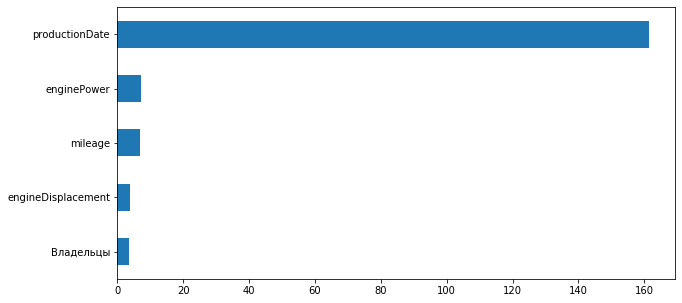

In [454]:
plt.figure(figsize=(10, 5))
imp_num = Series(f_classif(train_p[num_cols], train_p['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

- Ого, самое существеное влияние оказывает признак год выпуска автомобиля!

##### Построим корреляционную карту Пирсона (тепловая карта).

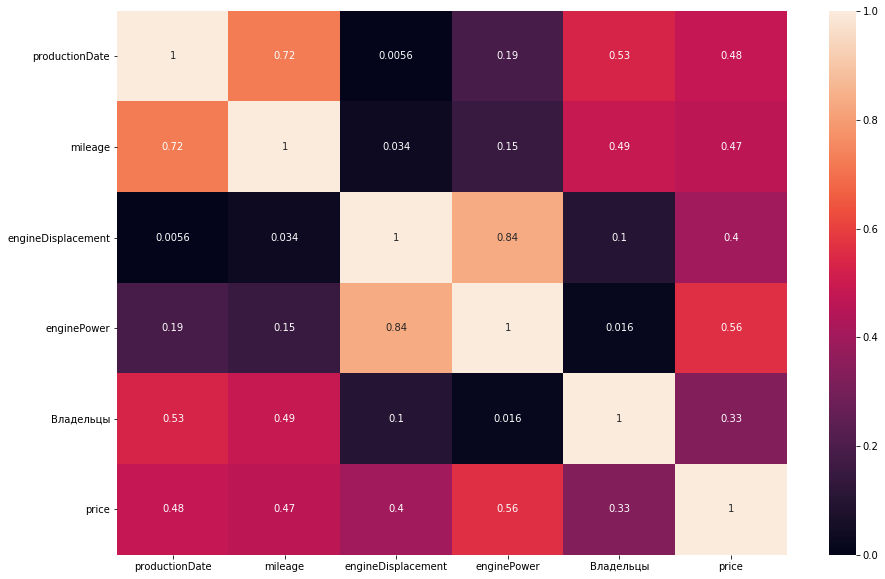

In [455]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(train_p.corr().abs(), vmin=0, vmax=1, annot = True)

- сильная положительная корреляция с ценой у признаков - мощность двигателя, объем двигателя и год выпуска.
- хорошая отрицательная корреляция у признаков - пробег и количество владельцев.

In [457]:
train_p.corr()

,productionDate,mileage,engineDisplacement,enginePower,Владельцы,price
productionDate,1.000000,-0.724350,-0.005641,0.190175,-0.534919,0.480722
mileage,-0.724350,1.000000,0.034409,-0.151400,0.489083,-0.466195
engineDisplacement,-0.005641,0.034409,1.000000,0.835573,0.099731,0.401726
enginePower,0.190175,-0.151400,0.835573,1.000000,0.015892,0.564145
Владельцы,-0.534919,0.489083,0.099731,0.015892,1.000000,-0.328243
price,0.480722,-0.466195,0.401726,0.564145,-0.328243,1.000000


In [231]:
X = train_p.drop(['price'], axis=1,)
y = train_p.price.values


In [232]:
X

,brand,model_name,productionDate,mileage,color,engineDisplacement,enginePower,fuelType,vehicleTransmission,Привод,Руль,Владельцы,ПТС,bodyType_cut
0,SKODA,FABIA,2009,168000,пурпурный,160,105,бензин,автоматическая,передний,Левый,2,Оригинал,хэтчбек
1,SKODA,OCTAVIA,2018,64000,бежевый,180,180,бензин,роботизированная,передний,Левый,2,Оригинал,хэтчбек
2,SKODA,YETI,2011,140257,коричневый,120,105,бензин,роботизированная,передний,Левый,2,Оригинал,внедорожник
3,SKODA,KODIAQ,2019,31301,бежевый,200,150,дизель,роботизированная,полный,Левый,2,Оригинал,внедорожник
4,SKODA,OCTAVIA_RS,2014,160000,зелёный,200,220,бензин,роботизированная,передний,Левый,3,Оригинал,хэтчбек
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45264,MITSUBISHI,LANCER,2012,114000,чёрный,160,117,бензин,автоматическая,передний,Левый,2,Оригинал,седан
45265,MITSUBISHI,OUTLANDER,2013,154638,белый,200,146,бензин,вариатор,полный,Левый,2,Оригинал,внедорожник
45266,MITSUBISHI,OUTLANDER,2018,12430,серебристый,200,146,бензин,вариатор,полный,Левый,1,Оригинал,внедорожник
45267,MITSUBISHI,OUTLANDER,2018,33018,белый,200,146,бензин,вариатор,передний,Левый,1,Оригинал,внедорожник


In [233]:
cat_cols = ['brand','model_name','color', 'fuelType', 'vehicleTransmission','Привод','Руль','ПТС','bodyType_cut' ]

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [235]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((29383, 14), (14473, 14), (29383,), (14473,))

In [236]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))
def print_learn_report(y_test, y_pred):
    
    print(f"Точность по метрике MAPE:{(mape(y_test, y_pred))*100:0.2f}%")

### CatBoostRegressor

In [237]:
start = datetime.now()
model_1 = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )
model_1.fit(X_train, y_train,
         cat_features=cat_cols,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )


y_pred = model_1.predict(X_test)

finish = datetime.now()

print(finish - start)
print_learn_report(y_test, y_pred)
#Точность по метрике MAPE:14.64%

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.5575162	test: 1.4941903	best: 1.4941903 (0)	total: 53.7ms	remaining: 1m 47s
100:	learn: 0.2518945	test: 0.2483963	best: 0.2483701 (99)	total: 3.07s	remaining: 57.8s
200:	learn: 0.1898140	test: 0.1923356	best: 0.1923356 (200)	total: 6.32s	remaining: 56.6s
300:	learn: 0.1695299	test: 0.1745983	best: 0.1745983 (300)	total: 9.37s	remaining: 52.9s
400:	learn: 0.1590710	test: 0.1658278	best: 0.1658036 (395)	total: 13.6s	remaining: 54.2s
500:	learn: 0.1524852	test: 0.1609044	best: 0.1608925 (498)	total: 16.6s	remaining: 49.7s
600:	learn: 0.1476526	test: 0.1576031	best: 0.1575336 (594)	total: 21.6s	remaining: 50.2s
700:	learn: 0.1439933	test: 0.1551081	best: 0.1550852 (699)	total: 24.8s	remaining: 46s
800:	learn: 0.1419237	test: 0.1542145	best: 0.1541141 (798)	total: 28.1s	remaining: 42.1s
900:	learn: 0.1396439	test: 0.1526643	best: 0.1526643 (900)	total: 31.5s	remaining: 38.4s
1000:	learn: 0.1369593	test: 0.1512152	best: 0.1511393 (993)	total: 34.9s	remaining: 34.8s
1100:	learn: 0

In [20]:
predict_submission = model_1.predict(test_p)
predict_submission

array([ 718921.3258463 ,  969928.06940859, 1023001.61971718, ...,
        295401.41923635, 1345833.89812715, 1113209.18898969])

In [665]:
VERSION = 5

sample_submission = pd.read_csv('sample_submission_auto.csv')
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission

,sell_id,price
0,1100575026,7.189213e+05
1,1100549428,9.699281e+05
2,1100658222,1.023002e+06
3,1100937408,7.467541e+05
4,1101037972,7.795971e+05
...,...,...
34681,1101369263,1.030582e+06
34682,1101369581,2.537885e+06
34683,1101364889,2.954014e+05
34684,1101362518,1.345834e+06


In [241]:
sample_submission = pd.read_csv('sample_submission_auto.csv')

#### Log Traget

Попробуем взять таргет в логарифм - это позволит уменьшить влияние выбросов (используем для этого np.log1p, np.expm1 (log(1+x) и exp(x)-1).

In [238]:

start = datetime.now()
model_2 = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )
model_2.fit(X_train, np.log1p(y_train),
         cat_features=cat_cols,
         eval_set=(X_test, np.log1p(y_test)),
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )


y_pred = np.expm1(model_2.predict(X_test))


finish = datetime.now()

print(finish - start)
print_learn_report(y_test, y_pred)




eval_set=(X_test, np.log1p(y_test))

#Точность по метрике MAPE:12.79%

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:01:36.570732
Точность по метрике MAPE:12.79%


Точность улучшилась до 12.79.

#### CV с логарифмом целевой переменной

Перед тем как бежать перебирать признаки и модели, поговорим о кросс-валидации (CV)

Когда мы делаем отбор признаков или перебираем настройки модели, мы постоянно смотрим в тестовые данные (X_test), что может привести к подгону под тестовые данные. В итоге мы получим Переобучение (overfitting).
Чтобы избежать этого, можно сразу использовать кросс-валидацию по фолдам (подробнее в модуле Классический Machine Learning >Модуль 7. Валидация данных >7.2. Разбиение выборки). 

Организуем обучение модели на 5 фолдах, с дальнейшим объединением предсказаний от каждой модели.

In [243]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              eval_metric='MAPE',
                              random_seed = RANDOM_SEED,)
    model.fit(X_train, np.log1p(y_train),
         cat_features=cat_cols,
         eval_set=(X_test, np.log1p(y_test)),
         verbose=False,
         use_best_model=True,
         plot=False
         )


    return(model)


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))



In [244]:
start = datetime.now()
submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты по каждой модели
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test,)
    # score model on test
    test_predict = np.expm1(model.predict(X_test))
    test_score = mape(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.3f}")
    # submissions
    submissions[f'sub_{idx+1}'] = np.expm1(model.predict(test_p))
    model.save_model(f'catboost_fold_{idx+1}.model')
finish = datetime.now()
print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

1 Fold Test MAPE: 0.127
2 Fold Test MAPE: 0.124
3 Fold Test MAPE: 0.126
4 Fold Test MAPE: 0.125
5 Fold Test MAPE: 0.122



TypeError: bad operand type for unary -: 'datetime.datetime'

In [245]:
print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

Mean Score: 0.125
Std Score: 0.0018
Max Score: 0.127
Min Score: 0.122


In [246]:
submissions.head(10)

,sub_1,sub_2,sub_3,sub_4,sub_5
0,7.337657e+05,7.127236e+05,6.969007e+05,7.287230e+05,7.018274e+05
1,1.007310e+06,9.853765e+05,9.712284e+05,9.730320e+05,9.950209e+05
2,9.790305e+05,9.919993e+05,9.658432e+05,1.008449e+06,9.569392e+05
3,7.983196e+05,7.612306e+05,7.878416e+05,8.087005e+05,7.708011e+05
4,7.449534e+05,7.702184e+05,7.547794e+05,7.469002e+05,7.341418e+05
5,8.134315e+05,8.202926e+05,8.329262e+05,8.195021e+05,8.237230e+05
6,7.199305e+05,7.207234e+05,7.141884e+05,7.028934e+05,7.219243e+05
7,4.475780e+05,4.396364e+05,4.423546e+05,4.465552e+05,4.559440e+05
8,1.999061e+06,2.027465e+06,1.985228e+06,2.047855e+06,2.004550e+06
9,8.352263e+05,8.143758e+05,8.221922e+05,7.889221e+05,7.968072e+05


In [247]:
VERSION = 6
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)
sample_submission['price'] = submissions['blend'].values
sample_submission.to_csv(f'submission_blend_log_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,7.147881e+05
1,1100549428,9.863935e+05
2,1100658222,9.804523e+05
3,1100937408,7.853787e+05
4,1101037972,7.501986e+05
5,1100912634,8.219751e+05
6,1101228730,7.159320e+05
7,1100165896,4.464136e+05
8,1100768262,2.012832e+06
9,1101218501,8.115047e+05


#### Обучим модели на числовых признаках.

In [251]:
cols_test_p = ['Руль',  'ПТС']
cols_train_p = ['Руль',  'ПТС']

In [256]:
# Для бинарных признаков 'cols_test' используем LabelEncoder
map_categories_test = {}  # Создаём словарь кодировок

label_encoder = LabelEncoder()

for column in cols_test_p:  # Организуем цикл по бинарным признакам и формируем словарь
    test_p[column] = label_encoder.fit_transform(test_p[column])
    map_categories_test[column] = dict(enumerate(label_encoder.classes_)) # Запоминаем, что закодировали
    

In [258]:
#Для признаков 'cols_train' используем LabelEncoder
map_categories_train = {}  # Создаём словарь кодировок

label_encoder = LabelEncoder()

for column in cols_train_p:  # Организуем цикл по бинарным признакам и формируем словарь
    train_p[column] = label_encoder.fit_transform(train_p[column])
    map_categories_train[column] = dict(enumerate(label_encoder.classes_)) # Запоминаем, что закодировали

In [262]:
#список категориальных признаков, но уже без двух признаков Руль и ПТС - их сделала цифровыми 
#c помощью label_encoder.
cat_cols_1 = ['brand',
 'model_name',
 'color',
 'fuelType',
 'vehicleTransmission',
 'Привод',
 'bodyType_cut']

In [263]:
y = train_p['price']
X = train_p.drop((cat_cols_1 + ['price']), axis =1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [264]:
X.head()

,productionDate,mileage,engineDisplacement,enginePower,Руль,Владельцы,ПТС
0,2009,168000,160,105,0,2,1
1,2018,64000,180,180,0,2,1
2,2011,140257,120,105,0,2,1
3,2019,31301,200,150,0,2,1
4,2014,160000,200,220,0,3,1


**GradientBoostingRegressor**

In [265]:
from sklearn.model_selection import RandomizedSearchCV
start = datetime.now()
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 8)],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]}

gbr = GradientBoostingRegressor()
gbr_random = RandomizedSearchCV(estimator = gbr, 
                                param_distributions = random_grid, n_iter = 100, 
                                cv = 3, verbose=10, random_state=RANDOM_SEED, n_jobs = -1)
gbr_random.fit(X_train, np.log(y_train))
finish = datetime.now()
print(finish-start)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 10

0:18:13.093468


In [266]:
#вычисляю лучшие параметры для модели GBR
gbr_random.best_params_

#{'n_estimators': 271,
# 'min_samples_split': 2,
# 'min_samples_leaf': 2,
# 'max_features': 'auto',
# 'max_depth': 7}

{'n_estimators': 271,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 7}

In [267]:
#обучаю модель на лучших параметрах

#gbr_random.best_params_:
#{'n_estimators': 271,
# 'min_samples_split': 2,
# 'min_samples_leaf': 2,
# 'max_features': 'auto',
# 'max_depth': 7}

best_gbr = GradientBoostingRegressor(random_state=RANDOM_SEED,
                       n_estimators=271,
                       min_samples_split=2,
                       min_samples_leaf=2,
                       max_features='auto',
                       max_depth=7)
best_gbr.fit(X_train, np.log(y_train))

predict_gbr = np.exp(best_gbr.predict(X_test))
print_learn_report(y_test, predict_gbr)
#Точность по метрике MAPE:16.96%

Точность по метрике MAPE:16.87%


#### Деревья

In [90]:
scaler = StandardScaler()

X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

In [91]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30699, 5), (13157, 5), (30699,), (13157,))

In [92]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#### RandomForestRegressor

In [93]:
start = datetime.now()
print(start)

rf = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, 
                               cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
finish = datetime.now()
print(finish - start )
y_pred_rf = rf_random.predict(X_test)
print_learn_report(y_test, y_pred_rf)

#Точность по метрике MAPE:19.12%

2021-03-15 12:44:59.773421
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 75.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 114.2min finished


1:54:46.924613
Точность по метрике MAPE:19.12%


In [95]:
#обучаю модель на лучших параметрах 

# rf_random.best_params_:
#{'n_estimators': 1400,
# 'min_samples_split': 2,
#'min_samples_leaf': 2,
#'max_features': 'auto',
# 'max_depth': 70,
# 'bootstrap': True}

start = datetime.now()

best_cv = RandomForestRegressor(random_state=RANDOM_SEED
                      , n_estimators=1400
                      , min_samples_split=2
                      , min_samples_leaf=2
                      , max_features='auto'
                      , max_depth=70)
best_cv.fit(X_train, np.log(y_train))

finish = datetime.now()
print(finish - start )
y_pred_cv = np.exp(best_cv.predict(X_test))
print_learn_report(y_test, y_pred_cv)

#Точность по метрике MAPE:16.79%

0:01:06.061729
Точность по метрике MAPE:16.79%


#### Бэггинг со случайным лесом

In [99]:

best_rfr = rf_random.best_estimator_
bagg_rfr = BaggingRegressor(best_rfr, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_rfr.fit(X_train, np.log(y_train))
predict_bagg_rfr = np.exp(bagg_rfr.predict(X_test))
print_learn_report(y_test, predict_bagg_rfr)
#Точность по метрике MAPE:17.37%

Точность по метрике MAPE:17.37%


#### Бэггинг c градиентным бустингом

In [107]:
start = datetime.now()
print(start)
bagg_gbr = BaggingRegressor(best_gbr, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_gbr.fit(X_train, np.log(y_train))
predict_bagg_gbr = np.exp(bagg_gbr.predict(X_test))
print_learn_report(y_test, predict_bagg_gbr)
finish = datetime.now()
print(finish - start)
#Точность по метрике MAPE:17.01%

2021-03-15 16:15:48.788826
Точность по метрике MAPE:17.01%
0:00:19.642676


#### Стеккинг. Ансамбли моделей

In [163]:
start = datetime.now()
print(start)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor




estimators=[
        ('rf', RandomForestRegressor(random_state=RANDOM_SEED,
                       n_estimators=1400,
                       min_samples_split=2,
                       min_samples_leaf=2,
                       max_features='auto',
                       max_depth=70)),
        ('gbr', GradientBoostingRegressor(random_state=RANDOM_SEED,
                                        n_estimators=271,
                                        min_samples_split=2,
                                        min_samples_leaf=2,
                                        max_features='auto',
                                        max_depth=7 ))
                                         
          
                                   
                    
        
            ]

sr = StackingRegressor(estimators=estimators,
                       final_estimator = CatBoostRegressor(iterations = ITERATIONS,
                                   learning_rate = LR,
                                   random_seed = RANDOM_SEED,
                                   eval_metric='MAPE',
                                   custom_metric=['R2', 'MAE']))
                                                           
                                                           

2021-03-15 21:15:53.657588


In [165]:
start = datetime.now()
print(start)

sr.fit(X_train, np.log(y_train))

finish = datetime.now()
print(finish - start)

2021-03-15 22:06:29.344125
0:	learn: 0.0485563	total: 5.45ms	remaining: 10.9s
1:	learn: 0.0441428	total: 8.73ms	remaining: 8.72s
2:	learn: 0.0402044	total: 13ms	remaining: 8.63s
3:	learn: 0.0368399	total: 16ms	remaining: 7.96s
4:	learn: 0.0336426	total: 19ms	remaining: 7.6s
5:	learn: 0.0307834	total: 22.2ms	remaining: 7.38s
6:	learn: 0.0282719	total: 25.2ms	remaining: 7.18s
7:	learn: 0.0260758	total: 28.2ms	remaining: 7.03s
8:	learn: 0.0241049	total: 31.4ms	remaining: 6.94s
9:	learn: 0.0223547	total: 34.4ms	remaining: 6.84s
10:	learn: 0.0208668	total: 37.4ms	remaining: 6.76s
11:	learn: 0.0195311	total: 40.6ms	remaining: 6.72s
12:	learn: 0.0184105	total: 43.5ms	remaining: 6.65s
13:	learn: 0.0174181	total: 46.6ms	remaining: 6.62s
14:	learn: 0.0165501	total: 49.6ms	remaining: 6.57s
15:	learn: 0.0158124	total: 52.7ms	remaining: 6.53s
16:	learn: 0.0151778	total: 55.6ms	remaining: 6.48s
17:	learn: 0.0146597	total: 58.7ms	remaining: 6.46s
18:	learn: 0.0142044	total: 61.9ms	remaining: 6.45s
19

176:	learn: 0.0116816	total: 763ms	remaining: 7.86s
177:	learn: 0.0116809	total: 821ms	remaining: 8.4s
178:	learn: 0.0116803	total: 827ms	remaining: 8.41s
179:	learn: 0.0116793	total: 834ms	remaining: 8.43s
180:	learn: 0.0116785	total: 839ms	remaining: 8.43s
181:	learn: 0.0116781	total: 843ms	remaining: 8.42s
182:	learn: 0.0116775	total: 846ms	remaining: 8.4s
183:	learn: 0.0116771	total: 853ms	remaining: 8.42s
184:	learn: 0.0116761	total: 856ms	remaining: 8.4s
185:	learn: 0.0116756	total: 859ms	remaining: 8.38s
186:	learn: 0.0116750	total: 862ms	remaining: 8.36s
187:	learn: 0.0116733	total: 866ms	remaining: 8.34s
188:	learn: 0.0116720	total: 869ms	remaining: 8.32s
189:	learn: 0.0116716	total: 872ms	remaining: 8.31s
190:	learn: 0.0116707	total: 875ms	remaining: 8.29s
191:	learn: 0.0116702	total: 879ms	remaining: 8.27s
192:	learn: 0.0116695	total: 882ms	remaining: 8.26s
193:	learn: 0.0116678	total: 886ms	remaining: 8.24s
194:	learn: 0.0116673	total: 890ms	remaining: 8.24s
195:	learn: 0.0

337:	learn: 0.0115687	total: 1.52s	remaining: 7.48s
338:	learn: 0.0115685	total: 1.53s	remaining: 7.49s
339:	learn: 0.0115682	total: 1.53s	remaining: 7.49s
340:	learn: 0.0115678	total: 1.54s	remaining: 7.48s
341:	learn: 0.0115667	total: 1.54s	remaining: 7.49s
342:	learn: 0.0115659	total: 1.55s	remaining: 7.49s
343:	learn: 0.0115652	total: 1.56s	remaining: 7.49s
344:	learn: 0.0115648	total: 1.56s	remaining: 7.5s
345:	learn: 0.0115646	total: 1.57s	remaining: 7.51s
346:	learn: 0.0115641	total: 1.58s	remaining: 7.51s
347:	learn: 0.0115631	total: 1.58s	remaining: 7.5s
348:	learn: 0.0115619	total: 1.58s	remaining: 7.49s
349:	learn: 0.0115616	total: 1.59s	remaining: 7.48s
350:	learn: 0.0115609	total: 1.59s	remaining: 7.47s
351:	learn: 0.0115594	total: 1.59s	remaining: 7.46s
352:	learn: 0.0115592	total: 1.6s	remaining: 7.45s
353:	learn: 0.0115585	total: 1.6s	remaining: 7.45s
354:	learn: 0.0115573	total: 1.6s	remaining: 7.44s
355:	learn: 0.0115568	total: 1.61s	remaining: 7.43s
356:	learn: 0.011

523:	learn: 0.0114692	total: 2.28s	remaining: 6.41s
524:	learn: 0.0114690	total: 2.28s	remaining: 6.41s
525:	learn: 0.0114683	total: 2.29s	remaining: 6.42s
526:	learn: 0.0114676	total: 2.3s	remaining: 6.42s
527:	learn: 0.0114672	total: 2.3s	remaining: 6.42s
528:	learn: 0.0114670	total: 2.31s	remaining: 6.42s
529:	learn: 0.0114665	total: 2.31s	remaining: 6.42s
530:	learn: 0.0114657	total: 2.32s	remaining: 6.41s
531:	learn: 0.0114651	total: 2.32s	remaining: 6.41s
532:	learn: 0.0114649	total: 2.33s	remaining: 6.41s
533:	learn: 0.0114644	total: 2.33s	remaining: 6.41s
534:	learn: 0.0114644	total: 2.34s	remaining: 6.41s
535:	learn: 0.0114641	total: 2.35s	remaining: 6.41s
536:	learn: 0.0114639	total: 2.35s	remaining: 6.4s
537:	learn: 0.0114635	total: 2.35s	remaining: 6.4s
538:	learn: 0.0114629	total: 2.36s	remaining: 6.39s
539:	learn: 0.0114626	total: 2.36s	remaining: 6.39s
540:	learn: 0.0114622	total: 2.37s	remaining: 6.38s
541:	learn: 0.0114618	total: 2.37s	remaining: 6.37s
542:	learn: 0.01

699:	learn: 0.0114030	total: 3.02s	remaining: 5.61s
700:	learn: 0.0114026	total: 3.03s	remaining: 5.61s
701:	learn: 0.0114023	total: 3.04s	remaining: 5.61s
702:	learn: 0.0114021	total: 3.04s	remaining: 5.61s
703:	learn: 0.0114018	total: 3.05s	remaining: 5.61s
704:	learn: 0.0114017	total: 3.05s	remaining: 5.61s
705:	learn: 0.0114014	total: 3.06s	remaining: 5.61s
706:	learn: 0.0114010	total: 3.06s	remaining: 5.6s
707:	learn: 0.0114008	total: 3.07s	remaining: 5.6s
708:	learn: 0.0114003	total: 3.07s	remaining: 5.6s
709:	learn: 0.0114000	total: 3.08s	remaining: 5.59s
710:	learn: 0.0113995	total: 3.08s	remaining: 5.59s
711:	learn: 0.0113991	total: 3.08s	remaining: 5.58s
712:	learn: 0.0113989	total: 3.09s	remaining: 5.58s
713:	learn: 0.0113984	total: 3.09s	remaining: 5.57s
714:	learn: 0.0113977	total: 3.1s	remaining: 5.57s
715:	learn: 0.0113974	total: 3.1s	remaining: 5.56s
716:	learn: 0.0113971	total: 3.1s	remaining: 5.55s
717:	learn: 0.0113969	total: 3.11s	remaining: 5.55s
718:	learn: 0.0113

884:	learn: 0.0113406	total: 3.78s	remaining: 4.76s
885:	learn: 0.0113404	total: 3.78s	remaining: 4.76s
886:	learn: 0.0113403	total: 3.79s	remaining: 4.75s
887:	learn: 0.0113399	total: 3.8s	remaining: 4.75s
888:	learn: 0.0113395	total: 3.8s	remaining: 4.75s
889:	learn: 0.0113393	total: 3.81s	remaining: 4.75s
890:	learn: 0.0113390	total: 3.81s	remaining: 4.75s
891:	learn: 0.0113388	total: 3.82s	remaining: 4.74s
892:	learn: 0.0113382	total: 3.83s	remaining: 4.74s
893:	learn: 0.0113377	total: 3.83s	remaining: 4.74s
894:	learn: 0.0113373	total: 3.83s	remaining: 4.73s
895:	learn: 0.0113372	total: 3.84s	remaining: 4.73s
896:	learn: 0.0113366	total: 3.84s	remaining: 4.72s
897:	learn: 0.0113365	total: 3.85s	remaining: 4.72s
898:	learn: 0.0113363	total: 3.85s	remaining: 4.71s
899:	learn: 0.0113362	total: 3.85s	remaining: 4.71s
900:	learn: 0.0113357	total: 3.86s	remaining: 4.7s
901:	learn: 0.0113354	total: 3.86s	remaining: 4.7s
902:	learn: 0.0113349	total: 3.86s	remaining: 4.69s
903:	learn: 0.01

1069:	learn: 0.0112867	total: 4.53s	remaining: 3.94s
1070:	learn: 0.0112866	total: 4.54s	remaining: 3.93s
1071:	learn: 0.0112864	total: 4.54s	remaining: 3.93s
1072:	learn: 0.0112861	total: 4.55s	remaining: 3.93s
1073:	learn: 0.0112857	total: 4.55s	remaining: 3.93s
1074:	learn: 0.0112854	total: 4.56s	remaining: 3.92s
1075:	learn: 0.0112853	total: 4.57s	remaining: 3.92s
1076:	learn: 0.0112849	total: 4.57s	remaining: 3.92s
1077:	learn: 0.0112848	total: 4.58s	remaining: 3.91s
1078:	learn: 0.0112846	total: 4.58s	remaining: 3.91s
1079:	learn: 0.0112846	total: 4.59s	remaining: 3.91s
1080:	learn: 0.0112843	total: 4.59s	remaining: 3.9s
1081:	learn: 0.0112840	total: 4.59s	remaining: 3.9s
1082:	learn: 0.0112838	total: 4.6s	remaining: 3.89s
1083:	learn: 0.0112834	total: 4.6s	remaining: 3.89s
1084:	learn: 0.0112830	total: 4.6s	remaining: 3.88s
1085:	learn: 0.0112829	total: 4.61s	remaining: 3.88s
1086:	learn: 0.0112823	total: 4.61s	remaining: 3.87s
1087:	learn: 0.0112821	total: 4.62s	remaining: 3.87

1254:	learn: 0.0112377	total: 5.28s	remaining: 3.13s
1255:	learn: 0.0112374	total: 5.29s	remaining: 3.13s
1256:	learn: 0.0112370	total: 5.29s	remaining: 3.13s
1257:	learn: 0.0112368	total: 5.3s	remaining: 3.12s
1258:	learn: 0.0112367	total: 5.3s	remaining: 3.12s
1259:	learn: 0.0112365	total: 5.31s	remaining: 3.12s
1260:	learn: 0.0112363	total: 5.32s	remaining: 3.12s
1261:	learn: 0.0112360	total: 5.32s	remaining: 3.11s
1262:	learn: 0.0112355	total: 5.33s	remaining: 3.11s
1263:	learn: 0.0112352	total: 5.33s	remaining: 3.1s
1264:	learn: 0.0112349	total: 5.34s	remaining: 3.1s
1265:	learn: 0.0112348	total: 5.34s	remaining: 3.1s
1266:	learn: 0.0112346	total: 5.35s	remaining: 3.09s
1267:	learn: 0.0112342	total: 5.35s	remaining: 3.09s
1268:	learn: 0.0112339	total: 5.35s	remaining: 3.08s
1269:	learn: 0.0112332	total: 5.36s	remaining: 3.08s
1270:	learn: 0.0112329	total: 5.36s	remaining: 3.08s
1271:	learn: 0.0112328	total: 5.37s	remaining: 3.07s
1272:	learn: 0.0112326	total: 5.37s	remaining: 3.07

1442:	learn: 0.0111908	total: 6.04s	remaining: 2.33s
1443:	learn: 0.0111906	total: 6.05s	remaining: 2.33s
1444:	learn: 0.0111904	total: 6.05s	remaining: 2.32s
1445:	learn: 0.0111903	total: 6.06s	remaining: 2.32s
1446:	learn: 0.0111902	total: 6.06s	remaining: 2.32s
1447:	learn: 0.0111900	total: 6.07s	remaining: 2.31s
1448:	learn: 0.0111899	total: 6.08s	remaining: 2.31s
1449:	learn: 0.0111897	total: 6.08s	remaining: 2.31s
1450:	learn: 0.0111895	total: 6.09s	remaining: 2.3s
1451:	learn: 0.0111895	total: 6.09s	remaining: 2.3s
1452:	learn: 0.0111893	total: 6.1s	remaining: 2.29s
1453:	learn: 0.0111891	total: 6.1s	remaining: 2.29s
1454:	learn: 0.0111889	total: 6.11s	remaining: 2.29s
1455:	learn: 0.0111884	total: 6.11s	remaining: 2.28s
1456:	learn: 0.0111882	total: 6.11s	remaining: 2.28s
1457:	learn: 0.0111881	total: 6.12s	remaining: 2.27s
1458:	learn: 0.0111879	total: 6.12s	remaining: 2.27s
1459:	learn: 0.0111878	total: 6.12s	remaining: 2.27s
1460:	learn: 0.0111874	total: 6.13s	remaining: 2.2

1629:	learn: 0.0111517	total: 6.8s	remaining: 1.54s
1630:	learn: 0.0111516	total: 6.8s	remaining: 1.54s
1631:	learn: 0.0111515	total: 6.81s	remaining: 1.53s
1632:	learn: 0.0111514	total: 6.82s	remaining: 1.53s
1633:	learn: 0.0111511	total: 6.82s	remaining: 1.53s
1634:	learn: 0.0111511	total: 6.83s	remaining: 1.52s
1635:	learn: 0.0111509	total: 6.84s	remaining: 1.52s
1636:	learn: 0.0111509	total: 6.84s	remaining: 1.52s
1637:	learn: 0.0111505	total: 6.84s	remaining: 1.51s
1638:	learn: 0.0111505	total: 6.85s	remaining: 1.51s
1639:	learn: 0.0111503	total: 6.85s	remaining: 1.5s
1640:	learn: 0.0111502	total: 6.86s	remaining: 1.5s
1641:	learn: 0.0111501	total: 6.86s	remaining: 1.5s
1642:	learn: 0.0111501	total: 6.87s	remaining: 1.49s
1643:	learn: 0.0111498	total: 6.87s	remaining: 1.49s
1644:	learn: 0.0111498	total: 6.88s	remaining: 1.48s
1645:	learn: 0.0111497	total: 6.88s	remaining: 1.48s
1646:	learn: 0.0111495	total: 6.88s	remaining: 1.48s
1647:	learn: 0.0111494	total: 6.89s	remaining: 1.47

1817:	learn: 0.0111142	total: 7.55s	remaining: 756ms
1818:	learn: 0.0111140	total: 7.56s	remaining: 752ms
1819:	learn: 0.0111136	total: 7.57s	remaining: 748ms
1820:	learn: 0.0111135	total: 7.57s	remaining: 744ms
1821:	learn: 0.0111133	total: 7.58s	remaining: 740ms
1822:	learn: 0.0111130	total: 7.58s	remaining: 736ms
1823:	learn: 0.0111130	total: 7.59s	remaining: 732ms
1824:	learn: 0.0111130	total: 7.59s	remaining: 728ms
1825:	learn: 0.0111128	total: 7.6s	remaining: 724ms
1826:	learn: 0.0111123	total: 7.6s	remaining: 720ms
1827:	learn: 0.0111120	total: 7.61s	remaining: 716ms
1828:	learn: 0.0111119	total: 7.61s	remaining: 712ms
1829:	learn: 0.0111118	total: 7.62s	remaining: 708ms
1830:	learn: 0.0111116	total: 7.62s	remaining: 703ms
1831:	learn: 0.0111114	total: 7.62s	remaining: 699ms
1832:	learn: 0.0111112	total: 7.63s	remaining: 695ms
1833:	learn: 0.0111109	total: 7.63s	remaining: 691ms
1834:	learn: 0.0111108	total: 7.64s	remaining: 687ms
1835:	learn: 0.0111107	total: 7.64s	remaining: 6

0:06:31.239918


In [167]:
predict_ensemble = np.exp(sr.predict(X_test))
print_learn_report(y_test, predict_ensemble)
#1 - Точность по метрике MAPE:16.64%
#2 - 

Точность по метрике MAPE:17.19%


- Делаю вывод, что обучение только на числовых признаках дает MAPE не слишком хороший. Поэтому перевожу все категориальные признакми в dummies и обучаю на всей выборке.

### Перевожу категориальные признаки в dummies.

In [268]:
#выделим топ-80 моделей (из 544), которые составляют 79 процентов записей в df_test. 
m_all = test.model_name.value_counts()
n = 0
p = 0
for m in m_all.index:
    n = n + 1
    p = p + m_all[m]
    if p >= (len(test)*79/100):
        break
m_top = m_all.head(n).index
len(m_top)

80

In [269]:
#функция, которая заменяет нетоповые модели на другие 'Other'.
def mod_top(x):
    if x in m_top:
        return x
    else:
        return 'Other'

test_p['model_top'] = test_p['model_name'].apply(mod_top)

In [270]:
train_p['model_top'] = train_p['model_name'].apply(mod_top)

In [271]:
cat_cols = ['bodyType_cut', 'vehicleTransmission', 'color', 'fuelType', 'Привод', 
            'model_top', 'brand', 'Руль', 'ПТС']

In [272]:
#создаю функцию для обработки признаков в dummies
def func_dum(df):
     
    dummies_bodyType_cut = pd.get_dummies(df['bodyType_cut']).rename(columns=lambda x: str(x))
    dummies_vehicleTransmission = pd.get_dummies(df['vehicleTransmission']).rename(columns=lambda x: str(x))
    dummies_color = pd.get_dummies(df['color']).rename(columns=lambda x: str(x))
    dummies_fuelType = pd.get_dummies(df['fuelType']).rename(columns=lambda x: str(x))
    dummies_privod = pd.get_dummies(df['Привод']).rename(columns=lambda x: str(x))
    dummies_model_top = pd.get_dummies(df['model_top']).rename(columns=lambda x: str(x))
    dummies_brand = pd.get_dummies(df['brand']).rename(columns=lambda x: str(x))
    dummies_Руль = pd.get_dummies(df['Руль']).rename(columns=lambda x: str(x))
    dummies_ПТС = pd.get_dummies(df['ПТС']).rename(columns=lambda x: str(x))


    df = pd.concat([df, dummies_vehicleTransmission, dummies_color,
               dummies_fuelType, dummies_privod, dummies_model_top, 
                    dummies_brand, dummies_Руль, dummies_ПТС], axis=1)
    df.drop(columns=cat_cols, inplace=True)
    df.drop(columns='model_name', inplace=True)
    return df

In [273]:
#Оборачиваем в функцию по обработке категориальных признаков в Dummies
train_pp = func_dum(train_p)
test_pp = func_dum(test_p)

In [275]:
train_pp

,productionDate,mileage,engineDisplacement,enginePower,Владельцы,price,автоматическая,вариатор,механическая,роботизированная,...,MITSUBISHI,NISSAN,SKODA,TOYOTA,VOLKSWAGEN,VOLVO,0,1,0,1
0,2009,168000,160,105,2,439000,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
1,2018,64000,180,180,2,1599000,0,0,0,1,...,0,0,1,0,0,0,1,0,0,1
2,2011,140257,120,105,2,549000,0,0,0,1,...,0,0,1,0,0,0,1,0,0,1
3,2019,31301,200,150,2,2099000,0,0,0,1,...,0,0,1,0,0,0,1,0,0,1
4,2014,160000,200,220,3,1500000,0,0,0,1,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45264,2012,114000,160,117,2,650000,1,0,0,0,...,1,0,0,0,0,0,1,0,0,1
45265,2013,154638,200,146,2,1045000,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1
45266,2018,12430,200,146,1,1735000,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1
45267,2018,33018,200,146,1,1480000,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1


In [278]:
X = train_pp.drop(['price'], axis=1,)
y = train_pp.price.values

In [283]:
scaler = StandardScaler()
X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [286]:
from sklearn.model_selection import RandomizedSearchCV
start = datetime.now()
print(start)
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 8)],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]}

gbr = GradientBoostingRegressor()
gbr_random = RandomizedSearchCV(estimator = gbr, 
                                param_distributions = random_grid, n_iter = 100, 
                                cv = 3, verbose=10, random_state=RANDOM_SEED, n_jobs = -1)
gbr_random.fit(X_train, np.log(y_train))
finish = datetime.now()
print(finish-start)

2021-03-16 18:55:23.793639
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 24

0:42:12.792558


In [287]:
gbr_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 7}

In [288]:
#обучаю модель на лучших параметрах

#{'n_estimators': 400,
#'min_samples_split': 2,
#'min_samples_leaf': 2,
# 'max_features': 'auto',
# 'max_depth': 7}

best_gbr_d = GradientBoostingRegressor(random_state=RANDOM_SEED,
                       n_estimators=400,
                       min_samples_split=2,
                       min_samples_leaf=2,
                       max_features='auto',
                       max_depth=7)
best_gbr_d.fit(X_train, np.log1p(y_train))

predict_gbr = np.expm1(best_gbr_d.predict(X_test))
print_learn_report(y_test, predict_gbr)
#Точность по метрике MAPE:13.28% без страндартизации
#Точность по метрике MAPE:13.29% со стандартизацией


Точность по метрике MAPE:13.29%


In [289]:
#бэггинг с градиентным бустингом
start = datetime.now()
print(start)
bagg_gbr = BaggingRegressor(best_gbr, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_gbr.fit(X_train, np.log(y_train))
predict_bagg_gbr = np.exp(bagg_gbr.predict(X_test))
print_learn_report(y_test, predict_bagg_gbr)
finish = datetime.now()
print(finish - start)
#Точность по метрике MAPE:13.53%

2021-03-16 19:40:24.409438
Точность по метрике MAPE:13.53%
0:01:08.059899


In [290]:
#деревья
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [291]:
start = datetime.now()
print(start)

rf = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, 
                               cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
finish = datetime.now()
print(finish - start )
y_pred_rf = rf_random.predict(X_test)
print_learn_report(y_test, y_pred_rf)

#Точность по метрике MAPE:14.88%

2021-03-16 20:00:39.099896
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 126.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 246.3min finished


4:12:27.025962
Точность по метрике MAPE:14.88%


In [292]:
#обучаю модель на лучших параметрах 
rf_random.best_params_
# rf_random.best_params_:
 #{'n_estimators': 2000,
 #'min_samples_split': 2,
 #'min_samples_leaf': 2,
 #'max_features': 'auto',
 #'max_depth': 90,
 #'bootstrap': True}

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': True}

In [300]:
start = datetime.now()

best_cv = RandomForestRegressor(
                        random_state=RANDOM_SEED
                      , n_estimators=2000
                      , min_samples_split=2
                      , min_samples_leaf=2
                      , max_features='auto'
                      , max_depth=90
                      ) 

best_cv.fit(X_train, np.log(y_train))

finish = datetime.now()
print(finish - start )
y_pred_cv = np.exp(best_cv.predict(X_test))
print_learn_report(y_test, y_pred_cv)

#Точность по метрике MAPE:13.49%


0:05:45.440451
Точность по метрике MAPE:13.49%


In [301]:
#бэггинг со случайным лесом
best_rfr = rf_random.best_estimator_
bagg_rfr = BaggingRegressor(best_rfr, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_rfr.fit(X_train, np.log(y_train))
predict_bagg_rfr = np.exp(bagg_rfr.predict(X_test))
print_learn_report(y_test, predict_bagg_rfr)
#Точность по метрике MAPE:13.73%

Точность по метрике MAPE:13.73%


#### Стеккинг. Ансамбли моделей


In [310]:
start = datetime.now()
print(start)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor




estimators=[
        ('rf', RandomForestRegressor(random_state=RANDOM_SEED,
                       n_estimators=2000,
                       min_samples_split=2,
                       min_samples_leaf=2,
                       max_features='auto',
                       max_depth=90)),
        ('gbr', GradientBoostingRegressor(random_state=RANDOM_SEED,
                                        n_estimators=400,
                                        min_samples_split=2,
                                        min_samples_leaf=2,
                                        max_features='auto',
                                        max_depth=7 ))
                                         
          
                                   
                    
        
            ]

sr = StackingRegressor(estimators=estimators,
                       final_estimator = CatBoostRegressor(iterations = ITERATIONS,
                                   learning_rate = LR,
                                   random_seed = RANDOM_SEED,
                                   eval_metric='MAPE',
                                   custom_metric=['R2', 'MAE']))
                                                           
                                                           

2021-03-17 09:05:49.144342


In [311]:
#обучаем стеккинг
start = datetime.now()
print(start)

sr.fit(X_train, np.log(y_train))

finish = datetime.now()
print(finish - start)

2021-03-17 09:50:12.207336
0:	learn: 0.0484266	total: 5.27ms	remaining: 10.5s
1:	learn: 0.0439117	total: 13.6ms	remaining: 13.6s
2:	learn: 0.0398585	total: 17.2ms	remaining: 11.4s
3:	learn: 0.0363891	total: 21.3ms	remaining: 10.6s
4:	learn: 0.0331718	total: 24.5ms	remaining: 9.76s
5:	learn: 0.0302427	total: 27.6ms	remaining: 9.18s
6:	learn: 0.0275920	total: 30.4ms	remaining: 8.66s
7:	learn: 0.0252789	total: 33.4ms	remaining: 8.3s
8:	learn: 0.0231966	total: 36.3ms	remaining: 8.03s
9:	learn: 0.0213287	total: 39.3ms	remaining: 7.83s
10:	learn: 0.0196805	total: 42.2ms	remaining: 7.63s
11:	learn: 0.0182519	total: 45.2ms	remaining: 7.48s
12:	learn: 0.0170000	total: 48.1ms	remaining: 7.35s
13:	learn: 0.0159254	total: 51.1ms	remaining: 7.25s
14:	learn: 0.0149602	total: 54ms	remaining: 7.14s
15:	learn: 0.0141850	total: 56.9ms	remaining: 7.05s
16:	learn: 0.0134916	total: 64.2ms	remaining: 7.48s
17:	learn: 0.0128688	total: 67.5ms	remaining: 7.43s
18:	learn: 0.0123400	total: 70.5ms	remaining: 7.35

209:	learn: 0.0093350	total: 750ms	remaining: 6.39s
210:	learn: 0.0093348	total: 754ms	remaining: 6.39s
211:	learn: 0.0093338	total: 757ms	remaining: 6.38s
212:	learn: 0.0093322	total: 760ms	remaining: 6.37s
213:	learn: 0.0093315	total: 763ms	remaining: 6.37s
214:	learn: 0.0093308	total: 767ms	remaining: 6.37s
215:	learn: 0.0093301	total: 773ms	remaining: 6.38s
216:	learn: 0.0093288	total: 778ms	remaining: 6.39s
217:	learn: 0.0093282	total: 781ms	remaining: 6.38s
218:	learn: 0.0093279	total: 784ms	remaining: 6.37s
219:	learn: 0.0093274	total: 787ms	remaining: 6.37s
220:	learn: 0.0093263	total: 790ms	remaining: 6.36s
221:	learn: 0.0093249	total: 793ms	remaining: 6.35s
222:	learn: 0.0093238	total: 796ms	remaining: 6.34s
223:	learn: 0.0093230	total: 799ms	remaining: 6.34s
224:	learn: 0.0093222	total: 803ms	remaining: 6.33s
225:	learn: 0.0093205	total: 806ms	remaining: 6.32s
226:	learn: 0.0093204	total: 809ms	remaining: 6.32s
227:	learn: 0.0093200	total: 812ms	remaining: 6.31s
228:	learn: 

394:	learn: 0.0092149	total: 1.49s	remaining: 6.07s
395:	learn: 0.0092142	total: 1.5s	remaining: 6.07s
396:	learn: 0.0092140	total: 1.5s	remaining: 6.07s
397:	learn: 0.0092131	total: 1.51s	remaining: 6.07s
398:	learn: 0.0092127	total: 1.51s	remaining: 6.07s
399:	learn: 0.0092124	total: 1.51s	remaining: 6.06s
400:	learn: 0.0092116	total: 1.52s	remaining: 6.05s
401:	learn: 0.0092112	total: 1.52s	remaining: 6.05s
402:	learn: 0.0092109	total: 1.52s	remaining: 6.04s
403:	learn: 0.0092106	total: 1.53s	remaining: 6.03s
404:	learn: 0.0092104	total: 1.53s	remaining: 6.03s
405:	learn: 0.0092101	total: 1.53s	remaining: 6.02s
406:	learn: 0.0092099	total: 1.54s	remaining: 6.01s
407:	learn: 0.0092091	total: 1.54s	remaining: 6.01s
408:	learn: 0.0092086	total: 1.54s	remaining: 6s
409:	learn: 0.0092083	total: 1.55s	remaining: 6.01s
410:	learn: 0.0092078	total: 1.55s	remaining: 6.01s
411:	learn: 0.0092072	total: 1.56s	remaining: 6s
412:	learn: 0.0092066	total: 1.56s	remaining: 6s
413:	learn: 0.0092058	t

597:	learn: 0.0091280	total: 2.25s	remaining: 5.27s
598:	learn: 0.0091275	total: 2.25s	remaining: 5.27s
599:	learn: 0.0091270	total: 2.25s	remaining: 5.26s
600:	learn: 0.0091266	total: 2.26s	remaining: 5.26s
601:	learn: 0.0091258	total: 2.26s	remaining: 5.25s
602:	learn: 0.0091256	total: 2.27s	remaining: 5.25s
603:	learn: 0.0091254	total: 2.27s	remaining: 5.24s
604:	learn: 0.0091247	total: 2.27s	remaining: 5.24s
605:	learn: 0.0091240	total: 2.27s	remaining: 5.23s
606:	learn: 0.0091233	total: 2.28s	remaining: 5.23s
607:	learn: 0.0091230	total: 2.29s	remaining: 5.23s
608:	learn: 0.0091229	total: 2.29s	remaining: 5.23s
609:	learn: 0.0091228	total: 2.29s	remaining: 5.23s
610:	learn: 0.0091225	total: 2.3s	remaining: 5.22s
611:	learn: 0.0091225	total: 2.3s	remaining: 5.21s
612:	learn: 0.0091222	total: 2.3s	remaining: 5.21s
613:	learn: 0.0091216	total: 2.31s	remaining: 5.21s
614:	learn: 0.0091215	total: 2.31s	remaining: 5.2s
615:	learn: 0.0091212	total: 2.31s	remaining: 5.19s
616:	learn: 0.00

795:	learn: 0.0090622	total: 3s	remaining: 4.54s
796:	learn: 0.0090621	total: 3s	remaining: 4.53s
797:	learn: 0.0090617	total: 3.01s	remaining: 4.53s
798:	learn: 0.0090614	total: 3.01s	remaining: 4.53s
799:	learn: 0.0090611	total: 3.01s	remaining: 4.52s
800:	learn: 0.0090607	total: 3.02s	remaining: 4.51s
801:	learn: 0.0090605	total: 3.03s	remaining: 4.52s
802:	learn: 0.0090605	total: 3.03s	remaining: 4.52s
803:	learn: 0.0090601	total: 3.03s	remaining: 4.51s
804:	learn: 0.0090600	total: 3.04s	remaining: 4.51s
805:	learn: 0.0090594	total: 3.04s	remaining: 4.5s
806:	learn: 0.0090592	total: 3.04s	remaining: 4.5s
807:	learn: 0.0090590	total: 3.05s	remaining: 4.5s
808:	learn: 0.0090588	total: 3.05s	remaining: 4.49s
809:	learn: 0.0090582	total: 3.05s	remaining: 4.49s
810:	learn: 0.0090579	total: 3.06s	remaining: 4.48s
811:	learn: 0.0090576	total: 3.06s	remaining: 4.48s
812:	learn: 0.0090574	total: 3.06s	remaining: 4.47s
813:	learn: 0.0090568	total: 3.07s	remaining: 4.47s
814:	learn: 0.0090563

995:	learn: 0.0090054	total: 3.75s	remaining: 3.78s
996:	learn: 0.0090051	total: 3.75s	remaining: 3.77s
997:	learn: 0.0090046	total: 3.76s	remaining: 3.77s
998:	learn: 0.0090043	total: 3.77s	remaining: 3.77s
999:	learn: 0.0090042	total: 3.77s	remaining: 3.77s
1000:	learn: 0.0090041	total: 3.77s	remaining: 3.77s
1001:	learn: 0.0090038	total: 3.78s	remaining: 3.76s
1002:	learn: 0.0090036	total: 3.78s	remaining: 3.76s
1003:	learn: 0.0090034	total: 3.79s	remaining: 3.76s
1004:	learn: 0.0090031	total: 3.79s	remaining: 3.75s
1005:	learn: 0.0090025	total: 3.79s	remaining: 3.75s
1006:	learn: 0.0090024	total: 3.8s	remaining: 3.74s
1007:	learn: 0.0090022	total: 3.8s	remaining: 3.74s
1008:	learn: 0.0090020	total: 3.8s	remaining: 3.74s
1009:	learn: 0.0090016	total: 3.81s	remaining: 3.73s
1010:	learn: 0.0090012	total: 3.81s	remaining: 3.73s
1011:	learn: 0.0090006	total: 3.82s	remaining: 3.73s
1012:	learn: 0.0090003	total: 3.82s	remaining: 3.72s
1013:	learn: 0.0089999	total: 3.82s	remaining: 3.72s
1

1197:	learn: 0.0089549	total: 4.5s	remaining: 3.01s
1198:	learn: 0.0089548	total: 4.51s	remaining: 3.01s
1199:	learn: 0.0089548	total: 4.51s	remaining: 3.01s
1200:	learn: 0.0089548	total: 4.51s	remaining: 3s
1201:	learn: 0.0089544	total: 4.51s	remaining: 3s
1202:	learn: 0.0089541	total: 4.52s	remaining: 2.99s
1203:	learn: 0.0089538	total: 4.52s	remaining: 2.99s
1204:	learn: 0.0089537	total: 4.52s	remaining: 2.98s
1205:	learn: 0.0089534	total: 4.53s	remaining: 2.98s
1206:	learn: 0.0089530	total: 4.53s	remaining: 2.98s
1207:	learn: 0.0089527	total: 4.53s	remaining: 2.97s
1208:	learn: 0.0089527	total: 4.54s	remaining: 2.97s
1209:	learn: 0.0089526	total: 4.54s	remaining: 2.97s
1210:	learn: 0.0089522	total: 4.55s	remaining: 2.96s
1211:	learn: 0.0089520	total: 4.55s	remaining: 2.96s
1212:	learn: 0.0089517	total: 4.56s	remaining: 2.96s
1213:	learn: 0.0089515	total: 4.56s	remaining: 2.95s
1214:	learn: 0.0089513	total: 4.56s	remaining: 2.95s
1215:	learn: 0.0089512	total: 4.57s	remaining: 2.94s


1394:	learn: 0.0089134	total: 5.25s	remaining: 2.28s
1395:	learn: 0.0089129	total: 5.25s	remaining: 2.27s
1396:	learn: 0.0089127	total: 5.25s	remaining: 2.27s
1397:	learn: 0.0089125	total: 5.26s	remaining: 2.26s
1398:	learn: 0.0089125	total: 5.26s	remaining: 2.26s
1399:	learn: 0.0089123	total: 5.26s	remaining: 2.26s
1400:	learn: 0.0089119	total: 5.27s	remaining: 2.25s
1401:	learn: 0.0089118	total: 5.27s	remaining: 2.25s
1402:	learn: 0.0089113	total: 5.28s	remaining: 2.25s
1403:	learn: 0.0089111	total: 5.28s	remaining: 2.24s
1404:	learn: 0.0089109	total: 5.29s	remaining: 2.24s
1405:	learn: 0.0089108	total: 5.29s	remaining: 2.23s
1406:	learn: 0.0089107	total: 5.29s	remaining: 2.23s
1407:	learn: 0.0089106	total: 5.3s	remaining: 2.23s
1408:	learn: 0.0089104	total: 5.3s	remaining: 2.22s
1409:	learn: 0.0089104	total: 5.3s	remaining: 2.22s
1410:	learn: 0.0089103	total: 5.31s	remaining: 2.21s
1411:	learn: 0.0089103	total: 5.31s	remaining: 2.21s
1412:	learn: 0.0089100	total: 5.31s	remaining: 2.

1590:	learn: 0.0088758	total: 6s	remaining: 1.54s
1591:	learn: 0.0088757	total: 6s	remaining: 1.54s
1592:	learn: 0.0088756	total: 6s	remaining: 1.53s
1593:	learn: 0.0088755	total: 6.01s	remaining: 1.53s
1594:	learn: 0.0088755	total: 6.01s	remaining: 1.53s
1595:	learn: 0.0088752	total: 6.02s	remaining: 1.52s
1596:	learn: 0.0088752	total: 6.02s	remaining: 1.52s
1597:	learn: 0.0088750	total: 6.02s	remaining: 1.51s
1598:	learn: 0.0088750	total: 6.03s	remaining: 1.51s
1599:	learn: 0.0088750	total: 6.03s	remaining: 1.51s
1600:	learn: 0.0088746	total: 6.03s	remaining: 1.5s
1601:	learn: 0.0088746	total: 6.04s	remaining: 1.5s
1602:	learn: 0.0088744	total: 6.04s	remaining: 1.5s
1603:	learn: 0.0088741	total: 6.04s	remaining: 1.49s
1604:	learn: 0.0088740	total: 6.05s	remaining: 1.49s
1605:	learn: 0.0088738	total: 6.05s	remaining: 1.48s
1606:	learn: 0.0088737	total: 6.05s	remaining: 1.48s
1607:	learn: 0.0088736	total: 6.06s	remaining: 1.48s
1608:	learn: 0.0088733	total: 6.07s	remaining: 1.47s
1609:

1779:	learn: 0.0088422	total: 6.74s	remaining: 833ms
1780:	learn: 0.0088422	total: 6.75s	remaining: 830ms
1781:	learn: 0.0088420	total: 6.75s	remaining: 826ms
1782:	learn: 0.0088418	total: 6.76s	remaining: 823ms
1783:	learn: 0.0088417	total: 6.76s	remaining: 819ms
1784:	learn: 0.0088415	total: 6.76s	remaining: 815ms
1785:	learn: 0.0088412	total: 6.77s	remaining: 811ms
1786:	learn: 0.0088408	total: 6.77s	remaining: 807ms
1787:	learn: 0.0088407	total: 6.77s	remaining: 803ms
1788:	learn: 0.0088402	total: 6.78s	remaining: 799ms
1789:	learn: 0.0088400	total: 6.78s	remaining: 796ms
1790:	learn: 0.0088398	total: 6.78s	remaining: 792ms
1791:	learn: 0.0088397	total: 6.79s	remaining: 788ms
1792:	learn: 0.0088392	total: 6.79s	remaining: 784ms
1793:	learn: 0.0088391	total: 6.8s	remaining: 781ms
1794:	learn: 0.0088390	total: 6.8s	remaining: 777ms
1795:	learn: 0.0088389	total: 6.81s	remaining: 773ms
1796:	learn: 0.0088389	total: 6.81s	remaining: 769ms
1797:	learn: 0.0088386	total: 6.81s	remaining: 7

1972:	learn: 0.0088098	total: 7.49s	remaining: 102ms
1973:	learn: 0.0088099	total: 7.49s	remaining: 98.7ms
1974:	learn: 0.0088096	total: 7.5s	remaining: 94.9ms
1975:	learn: 0.0088095	total: 7.5s	remaining: 91.1ms
1976:	learn: 0.0088095	total: 7.5s	remaining: 87.3ms
1977:	learn: 0.0088093	total: 7.5s	remaining: 83.5ms
1978:	learn: 0.0088092	total: 7.51s	remaining: 79.7ms
1979:	learn: 0.0088090	total: 7.51s	remaining: 75.9ms
1980:	learn: 0.0088086	total: 7.51s	remaining: 72.1ms
1981:	learn: 0.0088082	total: 7.52s	remaining: 68.3ms
1982:	learn: 0.0088081	total: 7.52s	remaining: 64.5ms
1983:	learn: 0.0088078	total: 7.53s	remaining: 60.7ms
1984:	learn: 0.0088077	total: 7.53s	remaining: 56.9ms
1985:	learn: 0.0088074	total: 7.54s	remaining: 53.1ms
1986:	learn: 0.0088073	total: 7.54s	remaining: 49.3ms
1987:	learn: 0.0088071	total: 7.54s	remaining: 45.5ms
1988:	learn: 0.0088070	total: 7.55s	remaining: 41.7ms
1989:	learn: 0.0088068	total: 7.55s	remaining: 37.9ms
1990:	learn: 0.0088068	total: 7.5

In [312]:
predict_ensemble = np.exp(sr.predict(X_test))
print_learn_report(y_test, predict_ensemble)
#Точность по метрике MAPE:13.67%

Точность по метрике MAPE:13.67%


##### Вывод

- Наилучшим образом показал себя CatBoost с кросс-валидацией (результат в ноутбуке 12.2). Результат на лидерборде 16.31092.
- Перевод категориальных признаков в dummies-переменные и обучение на разных моделях дал точность 13 процентов по метрике MAPE, что на 1% меньше, чем у CatBoost.
- Использование Stacking не принесло ожидаемого улучшения качества предсказаний.
- Наилучший результат имело применение GradientBoosting.
Становится понятно, что данные не слишком обогащенные разными фичами, но на парсинге я потеряла очень много времени и парсить дальше у меня нет ни сил ни времени. Считаю, что результат и так неплохой для моего уровня. 
- В следующий раз при парсинге постараюсь скачать побольше данных, попробую обработать слова. 